In [1]:
import collections
import matplotlib.pyplot as plt
import getpass
import glob
import itertools
import json
import numpy as np
import os
import openml
import pandas as pd
import scipy.stats

from plot_utils.style import style_dc
from plot_utils.common_plots import rank, average_plot
from plot_utils.common_tables import collect_data_for_final_table, do_wilcoxon_test
from plot_utils.common_loading import load_from_openml

import sys
sys.path.append("/home/eggenspk/Work/Project/2020_PoSH_Autosklearn/2020_IEEE_Autosklearn_experiments/experiment_scripts/")
sys.path.append("/home/feurerm/sync_dir/projects/2020_posh/2020_IEEE_Autosklearn_experiments/experiment_scripts")
from utils import openml_automl_benchmark, automl_test_benchmark, get_normalization_constants

In [2]:
username = getpass.getuser()
dir_ = {
    'eggenspk': "/home/eggenspk/Work/data/ASKL_20/",
    'feurerm': "/home/feurerm/projects/2021_posh_new/",
}[username]

valid_pretty = {
    #1: {
    #('auto', "port", "1MIN/RQ2.3_AutoAuto_simulate/dynamic/autoauto"): "Selector (PORT)",
    #('auto', "port", "1MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto"): "Selector (PORT, no fallback)",
    #('auto', "port", "1MIN/RQ2.3_AutoAuto_simulate/static/autoauto"): "Single best (PORT)",
    #('auto', "port+BO", "1MIN/AutoAuto_simulate/dynamic/autoauto"): "Selector (PORT+BO)",
    #('auto', "port+BO", "1MIN/AutoAuto_simulate/dynamic-no-fallback/autoauto"): "Selector (PORT+BO, no fallback)",
    #('auto', "port+BO", "1MIN/AutoAuto_simulate/static/autoauto"): "Single best (PORT+BO)",
    #('auto', "port+BO-ens", "1MIN/RQ1_AutoAuto_simulate/dynamic/autoauto"): "Selector (PORT+BO+ENS)",
    #('auto', "port+BO-ens", "1MIN/RQ1_AutoAuto_simulate/static/autoauto"): "Single best (PORT+BO+ENS)",
    #('auto', "port+BO-ens", "1MIN/RQ1_AutoAuto_simulate/dynamic-no-fallback/autoauto"): "Selector (PORT+BO+ENS, no fallback)",
    #
    #(None, None, "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_holdout_iterative_es_if"): "holdout",
    #(None, None, "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "SH; holdout",
    #(None, None, "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_3CV_iterative_es_if"): "3CV",
    #(None, None, "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_3CV_iterative_es_if"): "SH; 3CV",
    #(None, None, "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_5CV_iterative_es_if"): "5CV",
    #(None, None, "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_5CV_iterative_es_if"): "SH; 5CV",
    #(None, None, "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_10CV_iterative_es_if"): "10CV",
    #(None, None, "1MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_10CV_iterative_es_if"): "SH; 10CV",
    #},
    
    10: {
    ('auto', "port", "10MIN/RQ2.3_AutoAuto_simulate/dynamic/autoauto"): "Selector (PORT)",
    ('auto', "port", "10MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto"): "Selector (PORT, no fallback)",
    ('auto', "port", "10MIN/RQ2.3_AutoAuto_simulate/static/autoauto"): "Single best (PORT)",
    ('auto', "port", "10MIN/RQ2.3_AutoAuto_simulate/static-no-fallback/autoauto"): "Single best (PORT, no fallback)",
    ('auto', "port+BO", "10MIN/AutoAuto_simulate/dynamic/autoauto"): "Selector (PORT+BO)",
    ('auto', "port+BO", "10MIN/AutoAuto_simulate/dynamic-no-fallback/autoauto"): "Selector (PORT+BO, no fallback)",
    ('auto', "port+BO", "10MIN/AutoAuto_simulate/static/autoauto"): "Single best (PORT+BO)",
    ('auto', "port+BO", "10MIN/AutoAuto_simulate/static-no-fallback/autoauto"): "Single best (PORT+BO, no fallback)",
    ('auto', "port+BO-ens", "10MIN/RQ1_AutoAuto_simulate/dynamic/autoauto"): "Selector (PORT+BO+ENS)",
    ('auto', "port+BO-ens", "10MIN/RQ1_AutoAuto_simulate/static/autoauto"): "Single best (PORT+BO+ENS)",
    ('auto', "port+BO-ens", "10MIN/RQ1_AutoAuto_simulate/dynamic-no-fallback/autoauto"): "Selector (PORT+BO+ENS, no fallback)",
    ('auto', "port+BO-ens", "10MIN/RQ1_AutoAuto_simulate/static-no-fallback/autoauto"): "Single best (PORT+BO+ENS, no fallback)",
    
    (None, None, "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_holdout_iterative_es_if"): "holdout",
    (None, None, "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "SH; holdout",
    (None, None, "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_3CV_iterative_es_if"): "3CV",
    (None, None, "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_3CV_iterative_es_if"): "SH; 3CV",
    (None, None, "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_5CV_iterative_es_if"): "5CV",
    (None, None, "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_5CV_iterative_es_if"): "SH; 5CV",
    (None, None, "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_10CV_iterative_es_if"): "10CV",
    (None, None, "10MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_10CV_iterative_es_if"): "SH; 10CV",
    },
    60: {
    ('auto', "port", "60MIN/RQ2.3_AutoAuto_simulate/dynamic/autoauto"): "Selector (PORT)",
    ('auto', "port", "60MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto"): "Selector (PORT, no fallback)",
    ('auto', "port", "60MIN/RQ2.3_AutoAuto_simulate/static/autoauto"): "Single best (PORT)",
    ('auto', "port", "60MIN/RQ2.3_AutoAuto_simulate/static-no-fallback/autoauto"): "Single best (PORT, no fallback)",
    ('auto', "port+BO", "60MIN/AutoAuto_simulate/dynamic/autoauto"): "Selector (PORT+BO)",
    ('auto', "port+BO", "60MIN/AutoAuto_simulate/dynamic-no-fallback/autoauto"): "Selector (PORT+BO, no fallback)",
    ('auto', "port+BO", "60MIN/AutoAuto_simulate/static/autoauto"): "Single best (PORT+BO)",
    ('auto', "port+BO", "60MIN/AutoAuto_simulate/static-no-fallback/autoauto"): "Single best (PORT+BO, no fallback)",
    ('auto', "port+BO-ens", "60MIN/RQ1_AutoAuto_simulate/dynamic/autoauto"): "Selector (PORT+BO+ENS)",
    ('auto', "port+BO-ens", "60MIN/RQ1_AutoAuto_simulate/static/autoauto"): "Single best (PORT+BO+ENS)",
    ('auto', "port+BO-ens", "60MIN/RQ1_AutoAuto_simulate/dynamic-no-fallback/autoauto"): "Selector (PORT+BO+ENS, no fallback)",
    ('auto', "port+BO-ens", "60MIN/RQ1_AutoAuto_simulate/static-no-fallback/autoauto"): "Single best (PORT+BO+ENS, no fallback)",
    
    (None, None, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_holdout_iterative_es_if"): "holdout",
    (None, None, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_holdout_iterative_es_if"): "SH; holdout",
    (None, None, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_3CV_iterative_es_if"): "3CV",
    (None, None, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_3CV_iterative_es_if"): "SH; 3CV",
    (None, None, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_5CV_iterative_es_if"): "5CV",
    (None, None, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_5CV_iterative_es_if"): "SH; 5CV",
    (None, None, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_None_10CV_iterative_es_if"): "10CV",
    (None, None, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble/RF/RF_SH-eta4-i_10CV_iterative_es_if"): "SH; 10CV",
    },
}

task_ids = openml_automl_benchmark
n_seeds = 10
#task_ids = automl_test_benchmark
#n_seeds = 3

res_dc = {}
miss = 0
for horizon in list(valid_pretty.keys()):
    res_dc[horizon] = {}
    for tid in task_ids:
        res_dc[horizon][tid] = {}
        for mode in list(valid_pretty[horizon].keys()):
            if type(mode) == tuple:
                auto, _, model_name = mode
            else:
                model_name = mode
                auto = None
            res_dc[horizon][tid][mode] = []
            for seed in range(n_seeds):
                if auto == "auto":
                    fl_tmpl = dir_ + model_name + "_%d_%d/ensemble_results_bac_%d_%d_0.000000thresh_50size_1.000000best.json" % (tid, seed, tid, seed)
                else:
                    fl_tmpl = dir_ + model_name + "_%d_%d_0_0/ensemble_results_bac_%d_%d_0.000000thresh_50size_1.000000best.json" % (tid, seed, tid, seed)
                fl = glob.glob(fl_tmpl)
                if len(fl) == 0:
                    if auto == "auto":
                        fl_tmpl = dir_ + model_name + "_%d_%d/result.json" % (tid, seed)
                    else:
                        fl_tmpl = dir_ + model_name + "_%d_%d_0_0/result.json" % (tid, seed)
                    fl = glob.glob(fl_tmpl) 
                    if len(fl) == 0:
                        miss += 1
                        print(fl_tmpl)
                        continue
                    else:
                        print(tid,  '### Ensemble missing, falling back to regular', fl[0])
                fl = fl[0]
                with open(fl, "r") as fh:
                    line = json.load(fh)
                    if "50" in line:
                        loss = line["50"]["trajectory"]
                    else:
                        loss = line["0"]["trajectory"]
                    loss = [(l[0], l[1]) for l in loss]
                    loss = dict(loss)
                    res_dc[horizon][tid][mode].append(loss)
print("Missing %d entries" % miss)

189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_189873_0/result.json
189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_189873_3/result.json
189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_189873_4/result.json
189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_189873_6/result.json
189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_189873_7/result.json
189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/10MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_1

189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_189873_0/result.json
189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_189873_2/result.json
189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_189873_3/result.json
189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_189873_4/result.json
189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_189873_5/result.json
189873 ### Ensemble missing, falling back to regular /home/feurerm/projects/2021_posh_new/60MIN/RQ2.3_AutoAuto_simulate/dynamic-no-fallback/autoauto_1

Missing 0 entries


In [3]:
# Artificially add oracle and random
for horizon in res_dc:
    if horizon == 600:
        continue
    rng = np.random.RandomState(1)
    for tid in task_ids:
        options = [k for k in res_dc[horizon][tid] if k[0] == None]
        # random
        rand_mode = ("random", "random")
        res_dc[horizon][tid][rand_mode] = []        
        choices = rng.choice(len(options), n_seeds)
        for s, c in enumerate(choices):
            res_dc[horizon][tid][rand_mode].append(res_dc[horizon][tid][options[c]][s])
        
        # oracle
        orac_mode = ("oracle", "oracle")
        res_dc[horizon][tid][orac_mode] = []
        for s in range(n_seeds):
            vals_for_this_seed = []
            for o in options:
                tmp_key = sorted(list(res_dc[horizon][tid][o][s].keys()))[-1]
                tmp = res_dc[horizon][tid][o][s][tmp_key]
                vals_for_this_seed.append(tmp)
            best = np.argmin(vals_for_this_seed)
            res_dc[horizon][tid][orac_mode].append(res_dc[horizon][tid][options[best]][s])
    valid_pretty[horizon][orac_mode] = "oracle"
    valid_pretty[horizon][rand_mode] = "random"

In [4]:
# Load some stuff from disc and openml - takes some time
tasks, task_ids_sorted_by_num_features = load_from_openml(task_ids)
min_diff_dc, _, _, _, _ = get_normalization_constants(
    results_dir=os.path.join(dir_, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble"),
    task_ids=task_ids,
    load=False,
    n_seeds=n_seeds,
)
tasks

Loaded tasks from openml
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 168797 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 168796 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_10CV_iterative_es_if
Could not find a runhistory for task ID 168796 and model selection strategyCould not find a runhistory for task ID RF_SH-eta

tid                                ttid    did  \
189871  189871  TaskType.SUPERVISED_CLASSIFICATION  41163   
189872  189872  TaskType.SUPERVISED_CLASSIFICATION  41164   
189873  189873  TaskType.SUPERVISED_CLASSIFICATION  41167   
168794  168794  TaskType.SUPERVISED_CLASSIFICATION  41165   
168792  168792  TaskType.SUPERVISED_CLASSIFICATION  41168   
168793  168793  TaskType.SUPERVISED_CLASSIFICATION  41166   
75105    75105  TaskType.SUPERVISED_CLASSIFICATION   1111   
189906  189906  TaskType.SUPERVISED_CLASSIFICATION  40984   
189909  189909  TaskType.SUPERVISED_CLASSIFICATION  41027   
189908  189908  TaskType.SUPERVISED_CLASSIFICATION  40996   
167185  167185  TaskType.SUPERVISED_CLASSIFICATION   1468   
189874  189874  TaskType.SUPERVISED_CLASSIFICATION  41169   
189861  189861  TaskType.SUPERVISED_CLASSIFICATION  41142   
189866  189866  TaskType.SUPERVISED_CLASSIFICATION  41147   
168797  168797  TaskType.SUPERVISED_CLASSIFICATION  41161   
168796  168796  TaskType.SUPERVISED_CLASSIFICATION  41159   
189860  189860  TaskType.SUPERVISED_CLASSIFICATION  41138   
189862  189862  TaskType.SUPERVISED_CLASSIFICATION  41143   
168798  168798  TaskType.SUPERVISED_CLASSIFICATION  41150   
189865  189865  TaskType.SUPERVISED_CLASSIFICATION  41146   
126026  126026  TaskType.SUPERVISED_CLASSIFICATION   1486   
167104  167104  TaskType.SUPERVISED_CLASSIFICATION  40981   
167083  167083  TaskType.SUPERVISED_CLASSIFICATION  23517   
189905  189905  TaskType.SUPERVISED_CLASSIFICATION  40975   
75127    75127  TaskType.SUPERVISED_CLASSIFICATION   1169   
167200  167200  TaskType.SUPERVISED_CLASSIFICATION  23512   
167184  167184  TaskType.SUPERVISED_CLASSIFICATION   1464   
167201  167201  TaskType.SUPERVISED_CLASSIFICATION  40668   
168795  168795  TaskType.SUPERVISED_CLASSIFICATION  40685   
126025  126025  TaskType.SUPERVISED_CLASSIFICATION   1590   
75097    75097  TaskType.SUPERVISED_CLASSIFICATION   4135   
167190  167190  TaskType.SUPERVISED_CLASSIFICATION   1489   
126029  126029  TaskType.SUPERVISED_CLASSIFICATION   1461   
167149  167149  TaskType.SUPERVISED_CLASSIFICATION      3   
167152  167152  TaskType.SUPERVISED_CLASSIFICATION     12   
167168  167168  TaskType.SUPERVISED_CLASSIFICATION     54   
167181  167181  TaskType.SUPERVISED_CLASSIFICATION   1067   
75193    75193  TaskType.SUPERVISED_CLASSIFICATION   1596   
167161  167161  TaskType.SUPERVISED_CLASSIFICATION     31   

                                          name                  task_type  \
189871                                 dilbert  Supervised Classification   
189872                                  fabert  Supervised Classification   
189873                                  dionis  Supervised Classification   
168794                                  robert  Supervised Classification   
168792                                  jannis  Supervised Classification   
168793                                 volkert  Supervised Classification   
75105                       KDDCup09_appetency  Supervised Classification   
189906                                 segment  Supervised Classification   
189909  jungle_chess_2pcs_raw_endgame_complete  Supervised Classification   
189908                           Fashion-MNIST  Supervised Classification   
167185                                  cnae-9  Supervised Classification   
189874                                  helena  Supervised Classification   
189861                               christine  Supervised Classification   
189866                                  albert  Supervised Classification   
168797                                riccardo  Supervised Classification   
168796                               guillermo  Supervised Classification   
189860                              APSFailure  Supervised Classification   
189862                                 jasmine  Supervised Classification   
168798                               MiniBooNE  Supervised Classification   
189865                        

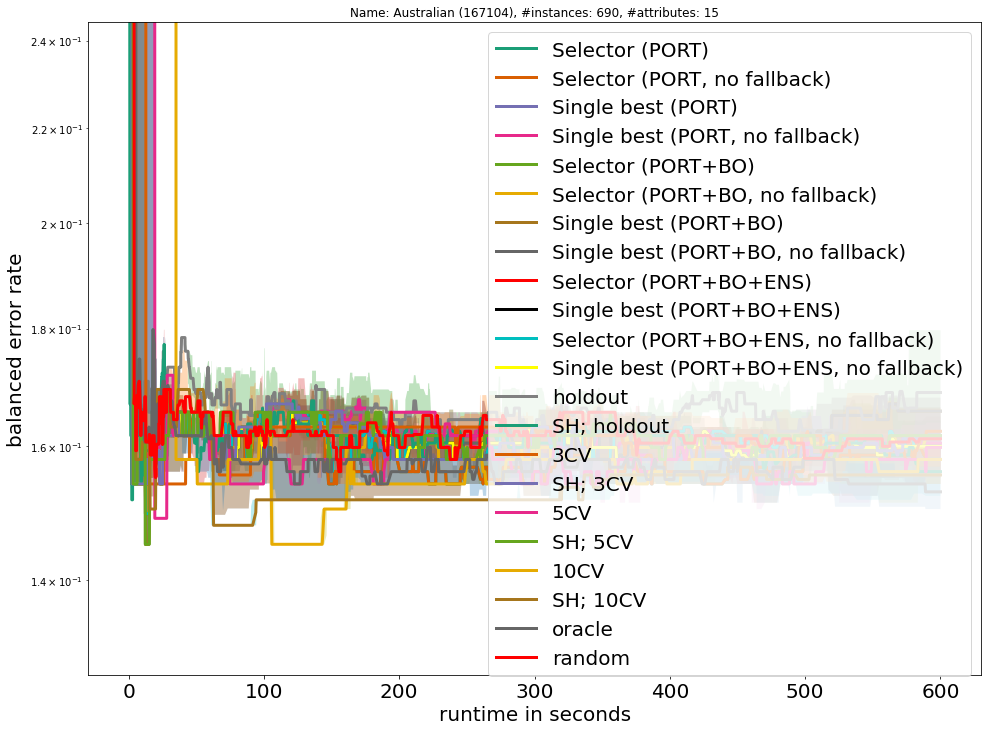

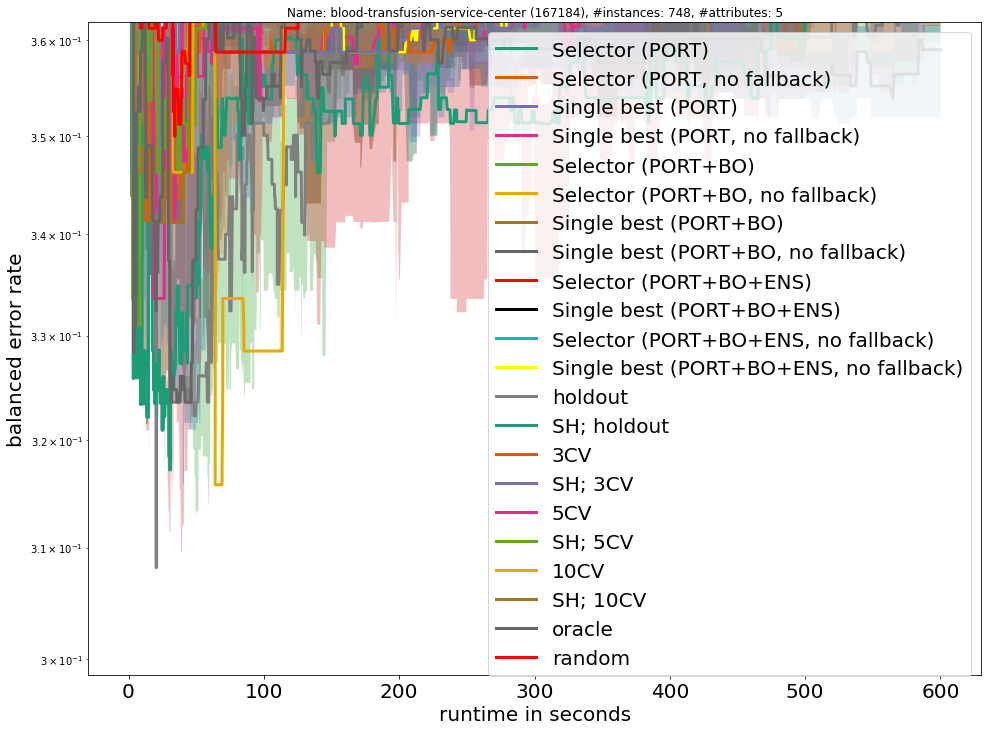

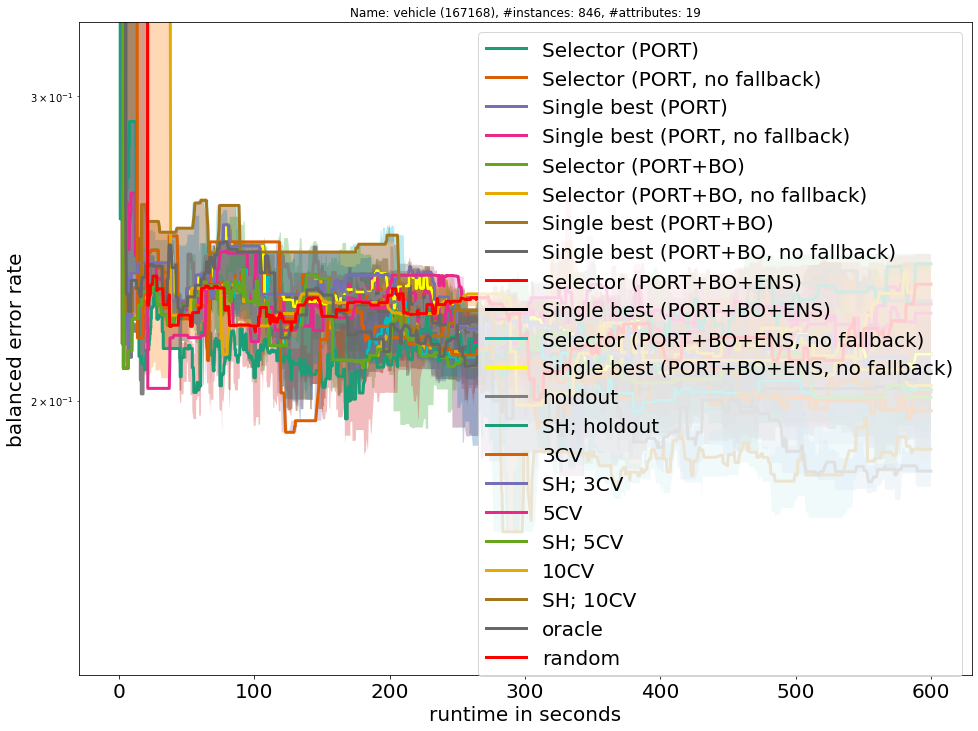

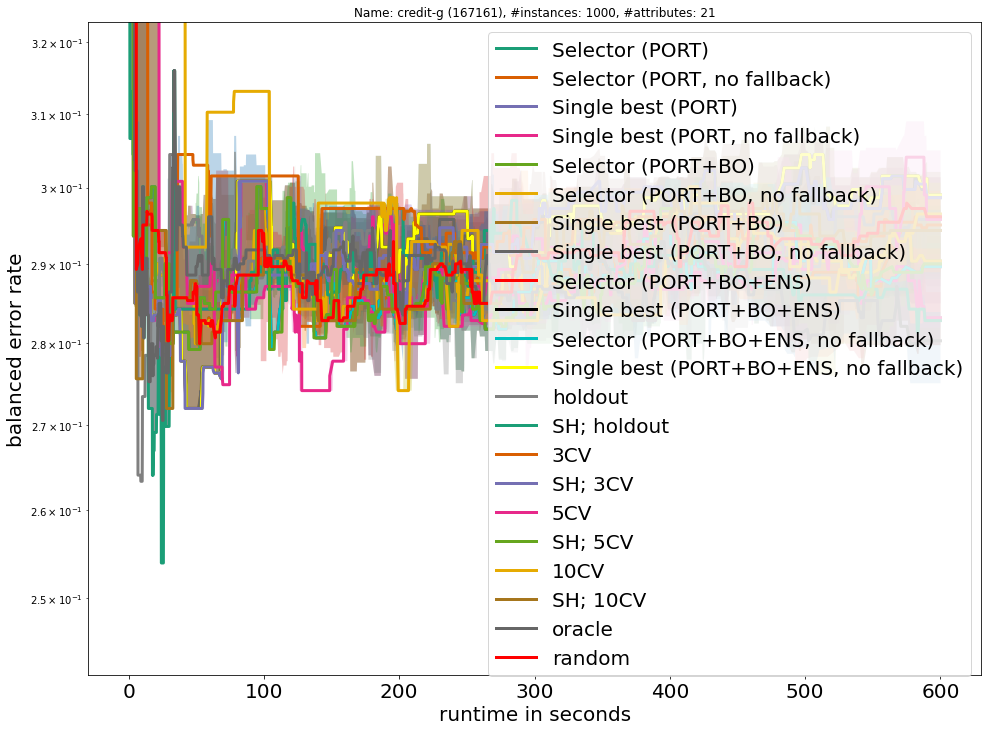

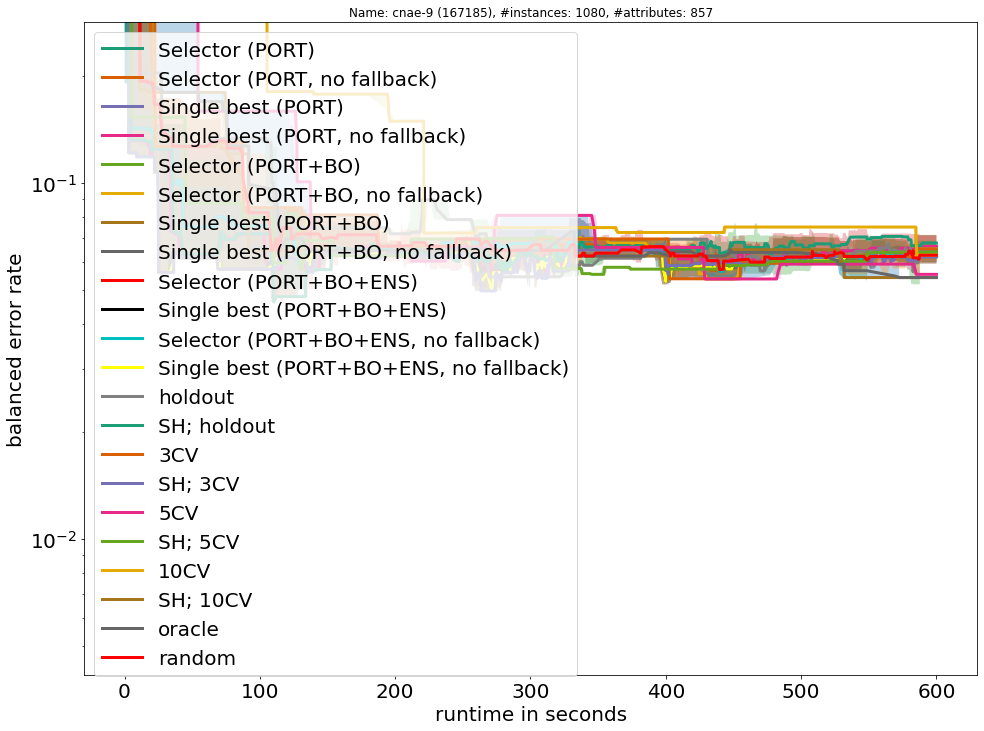

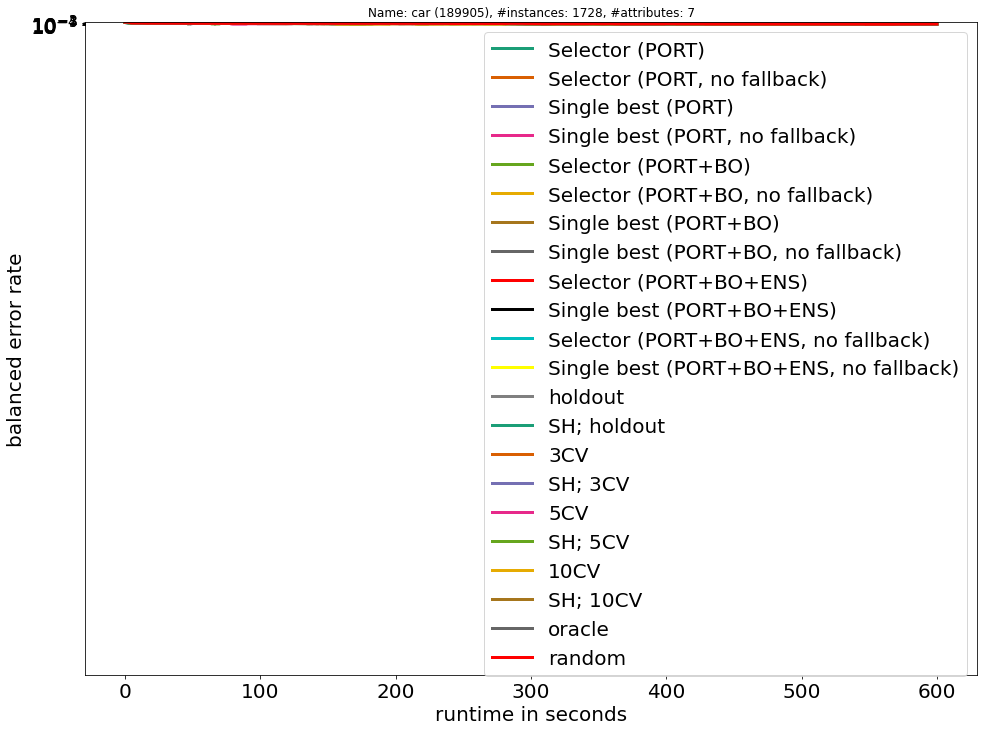

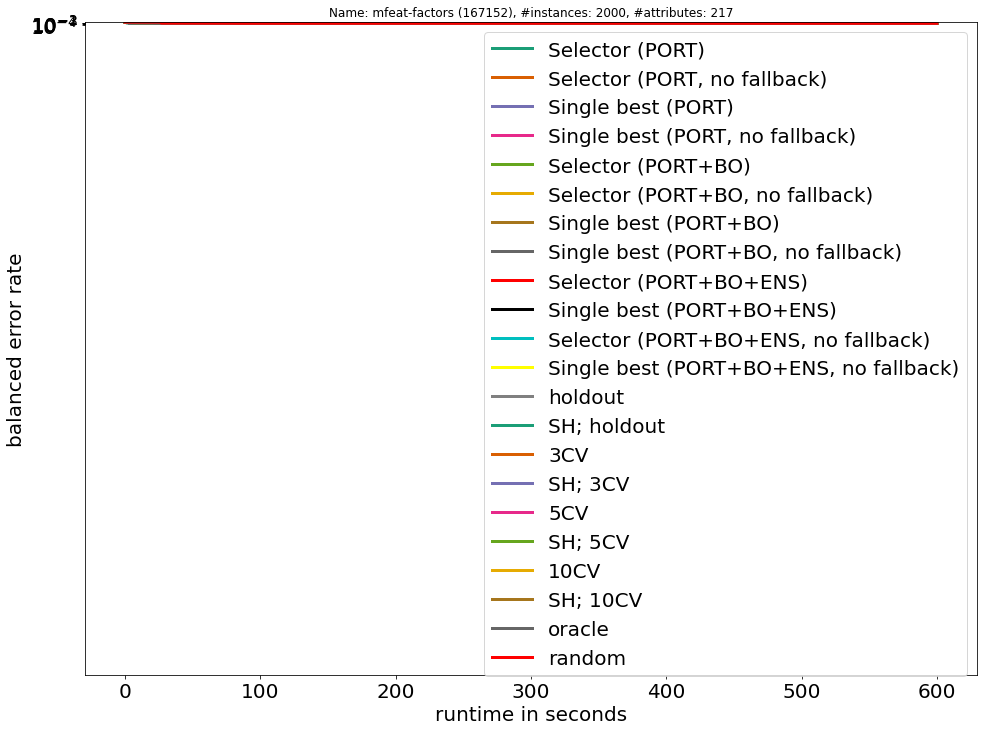

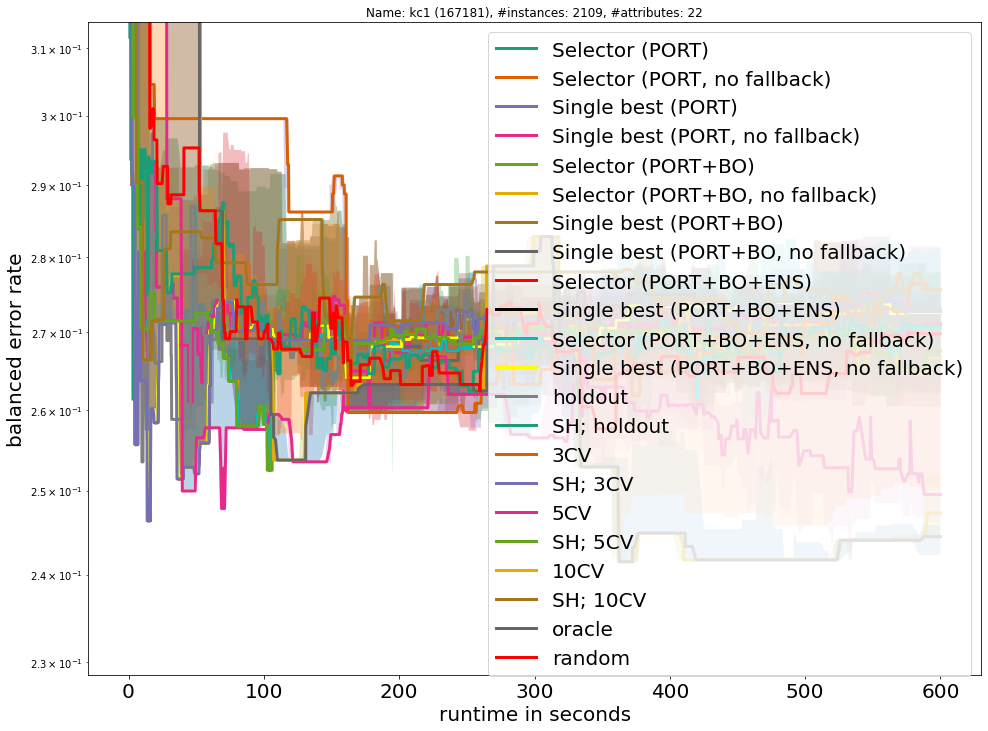

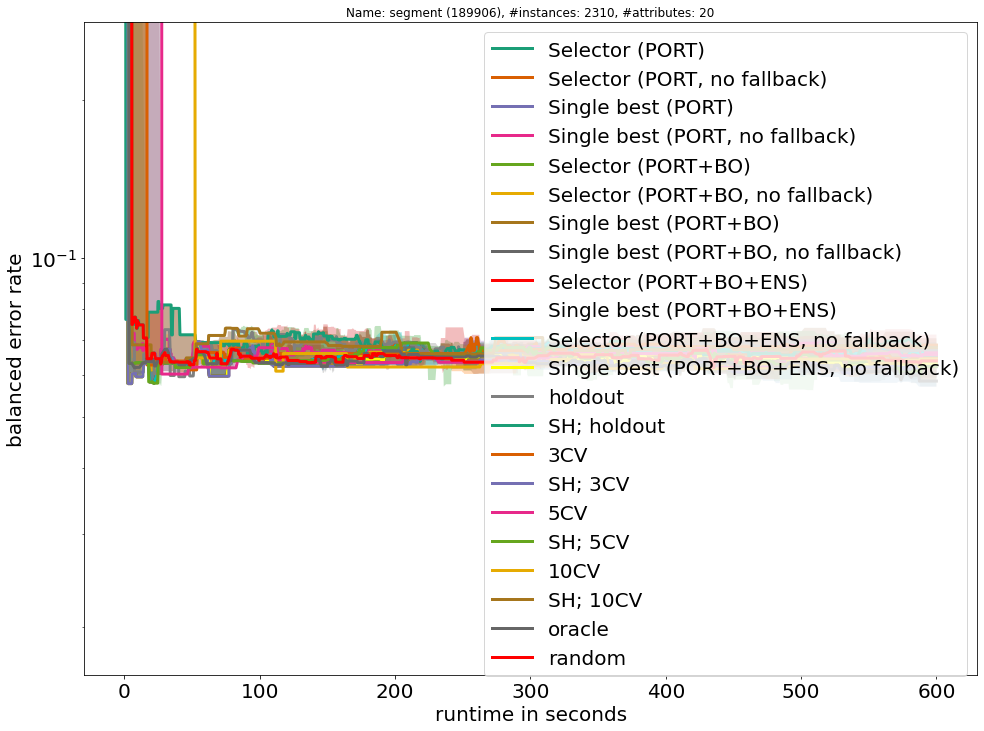

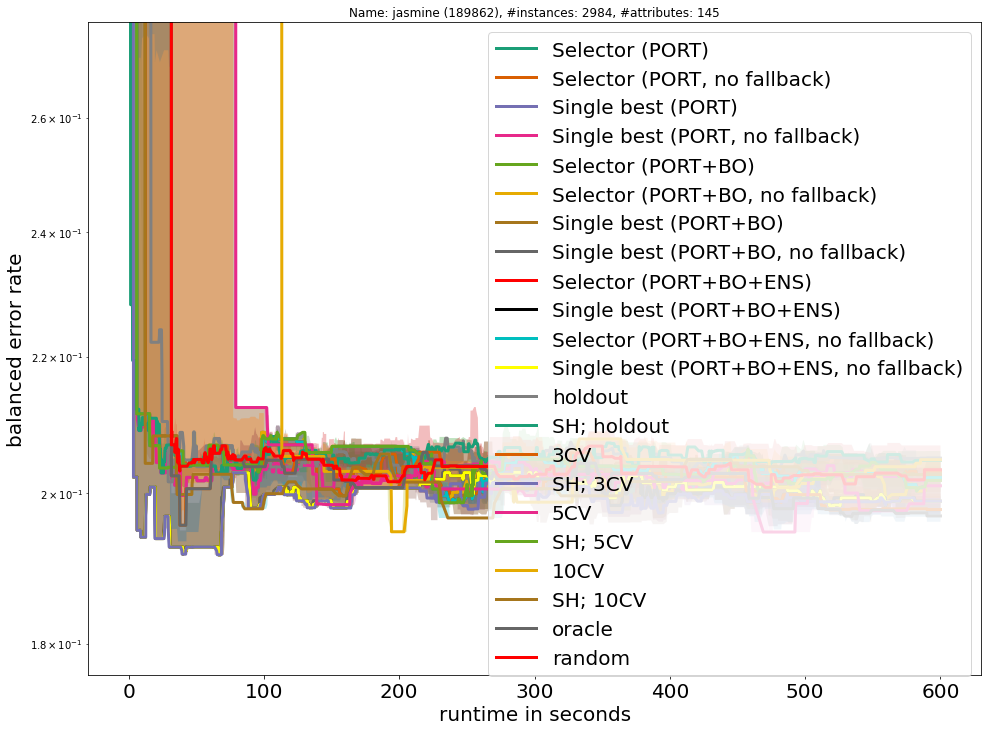

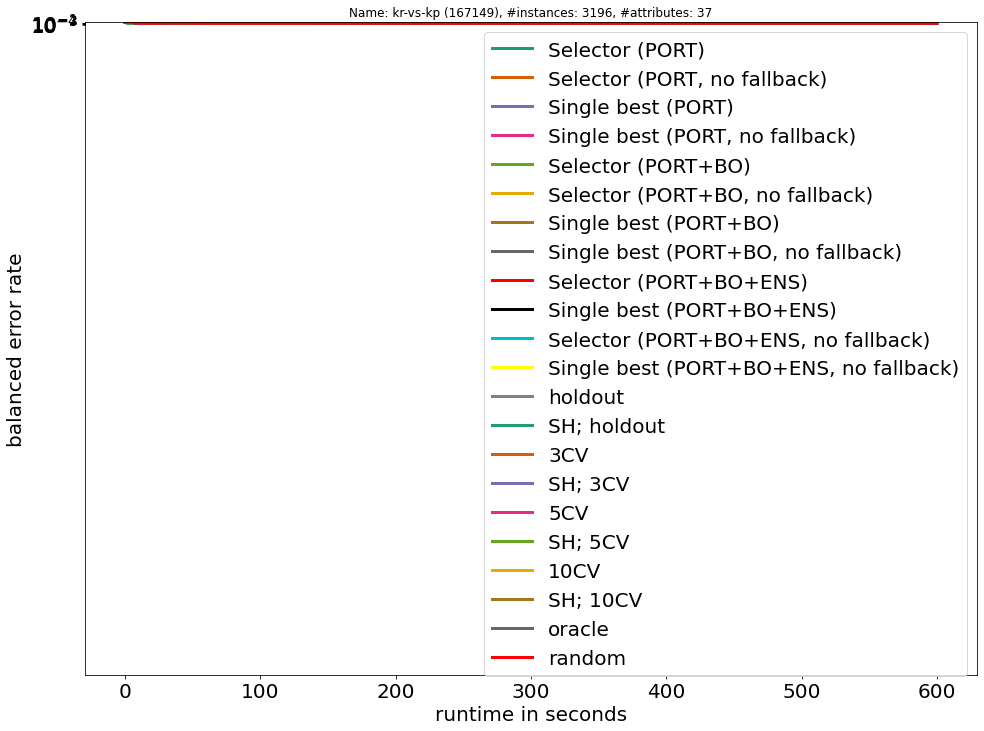

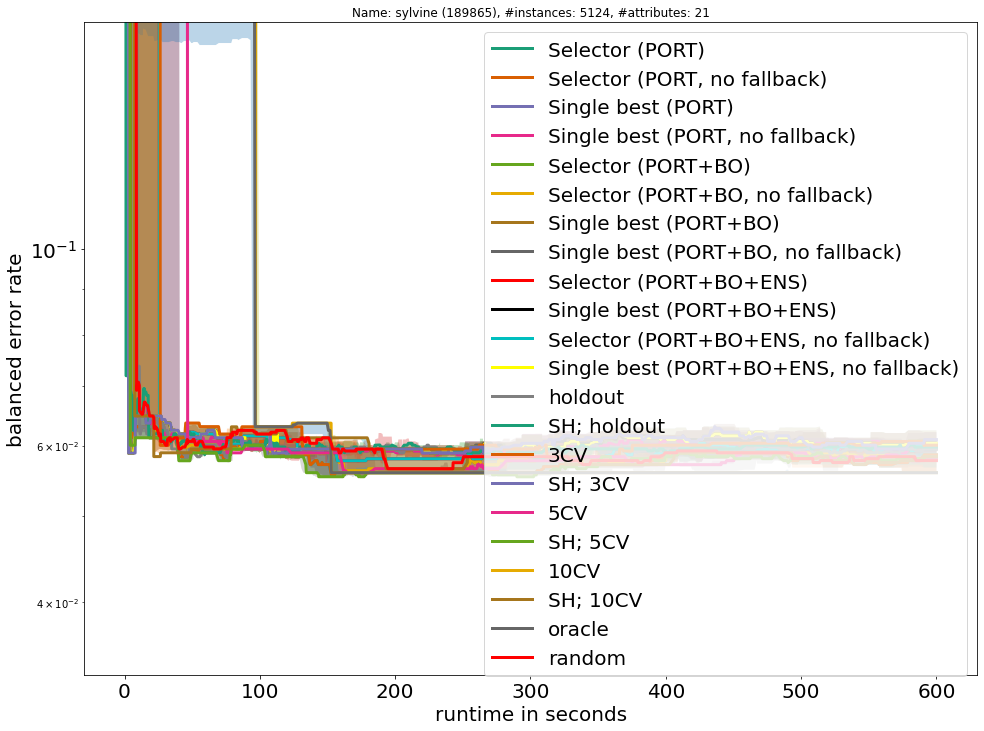

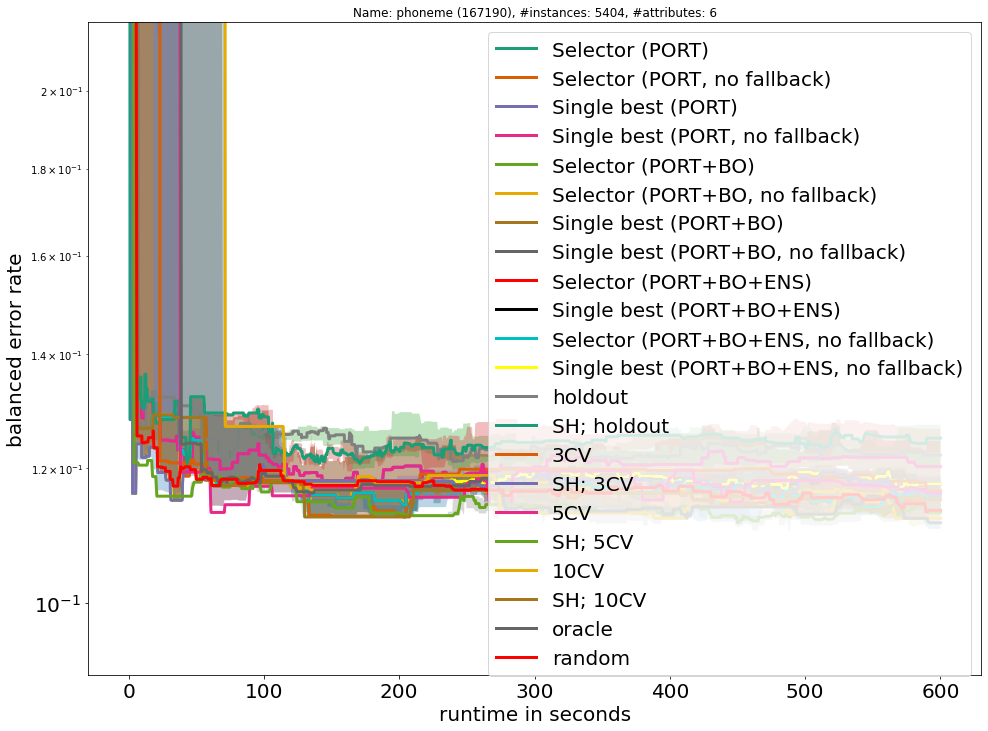

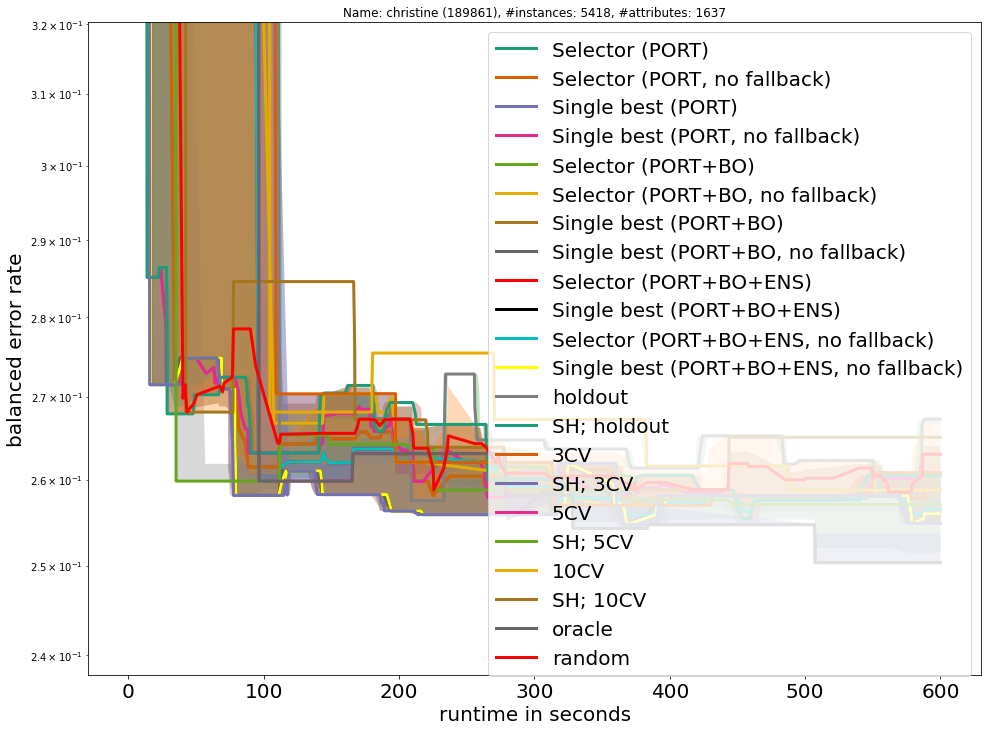

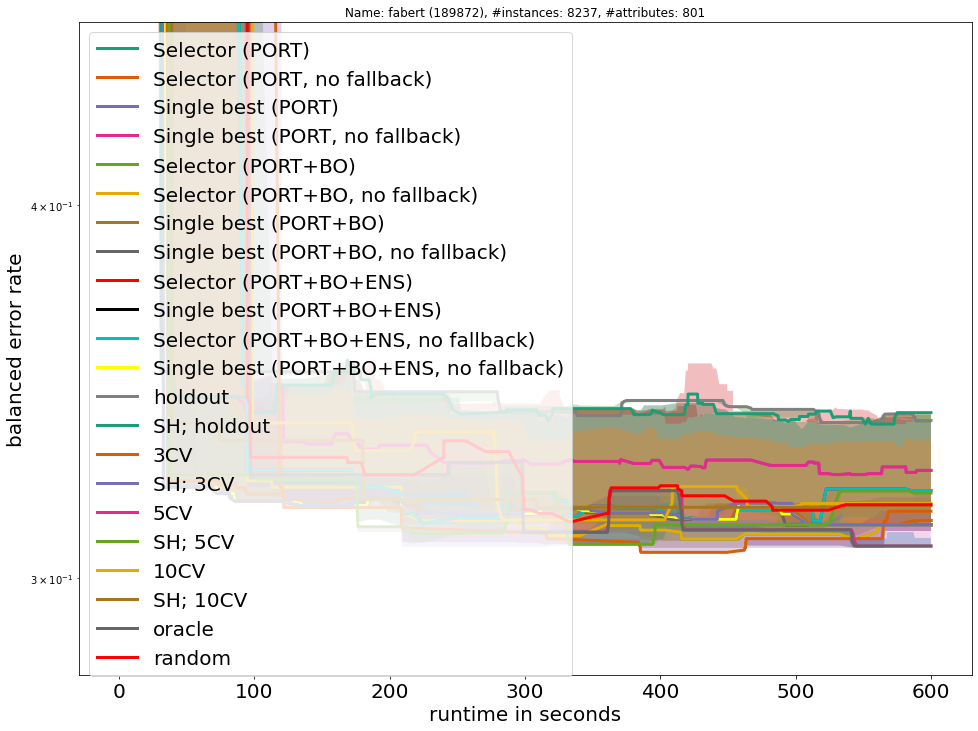

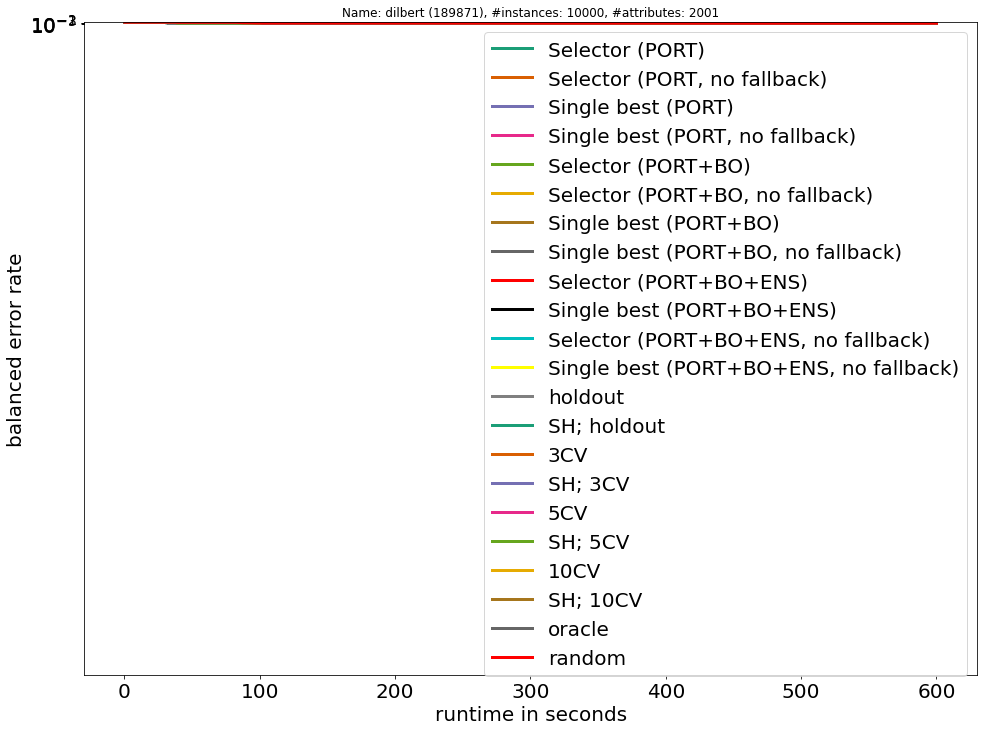

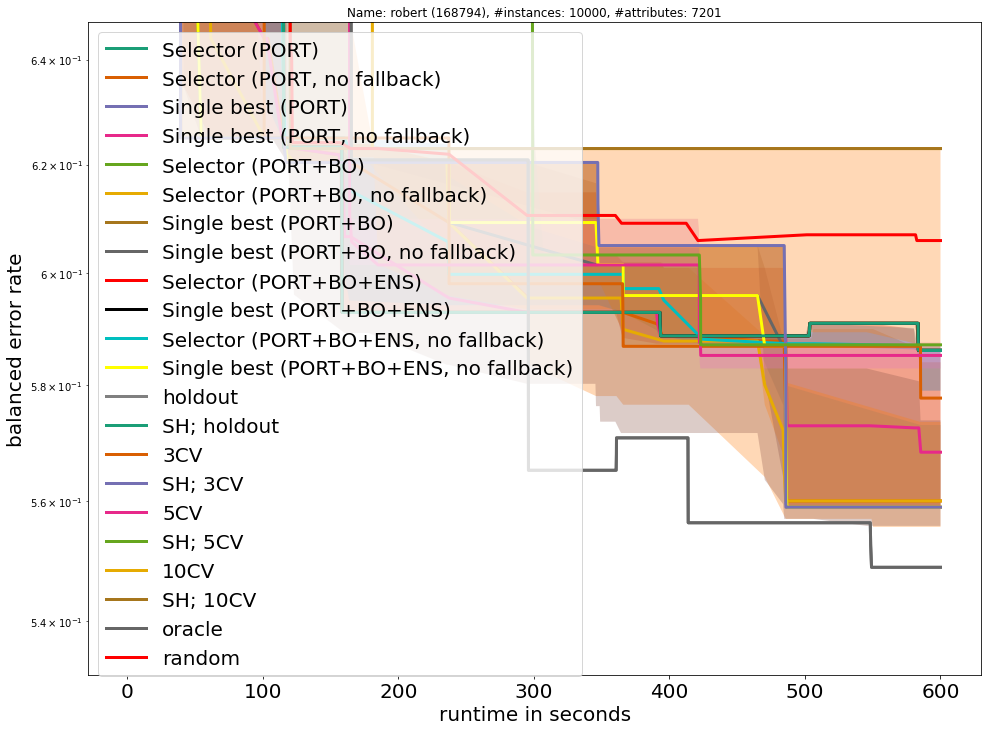

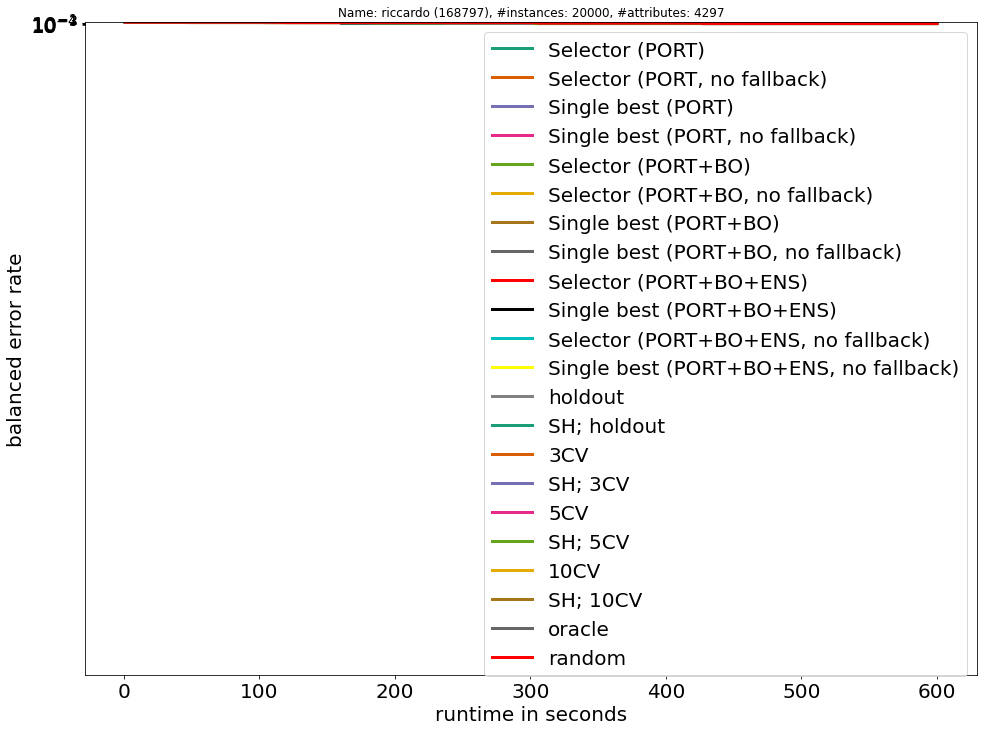

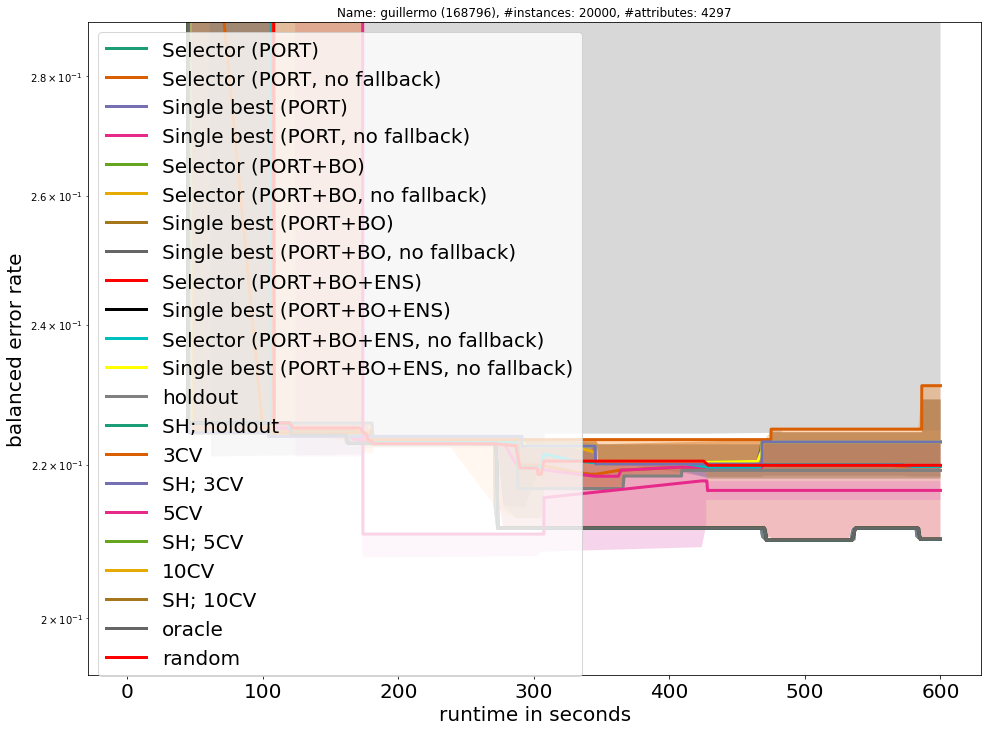

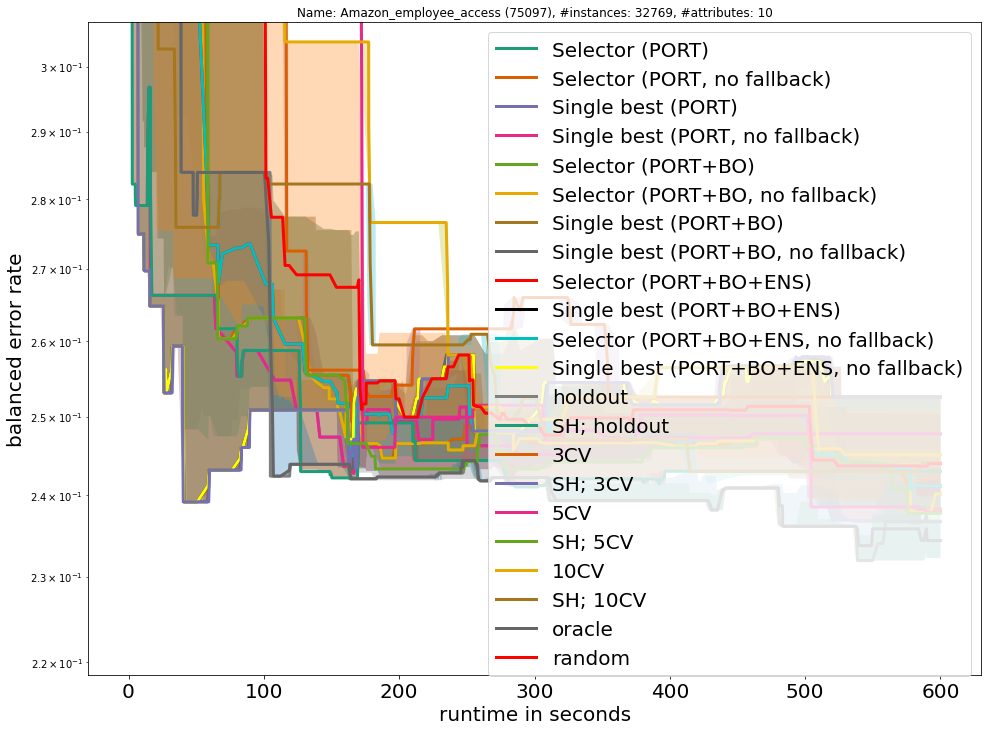

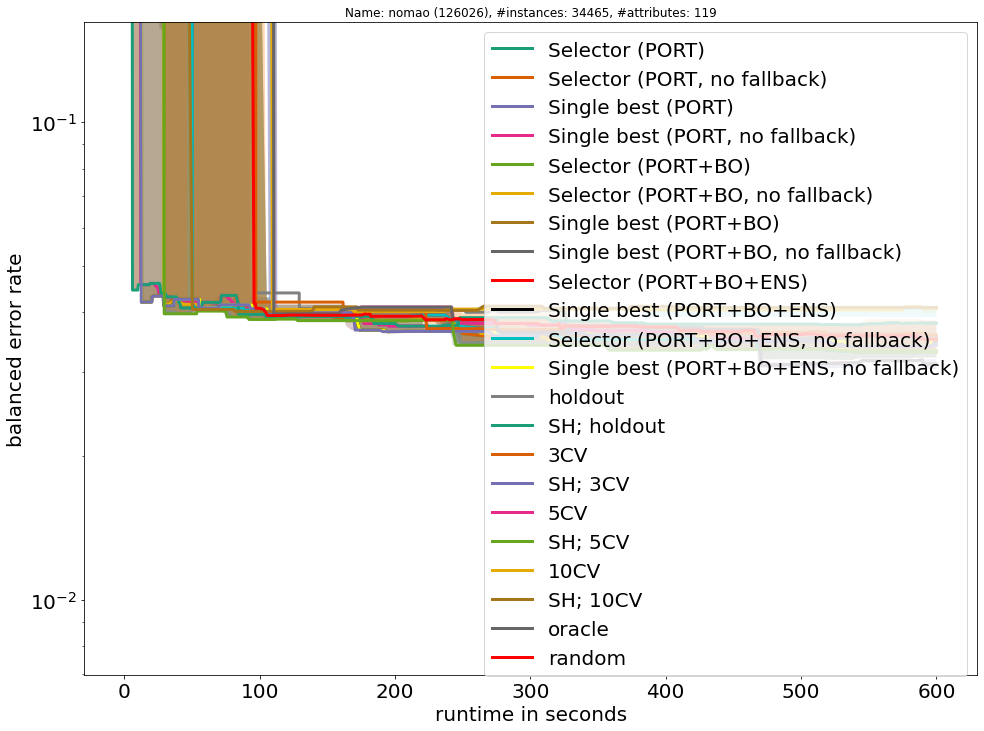

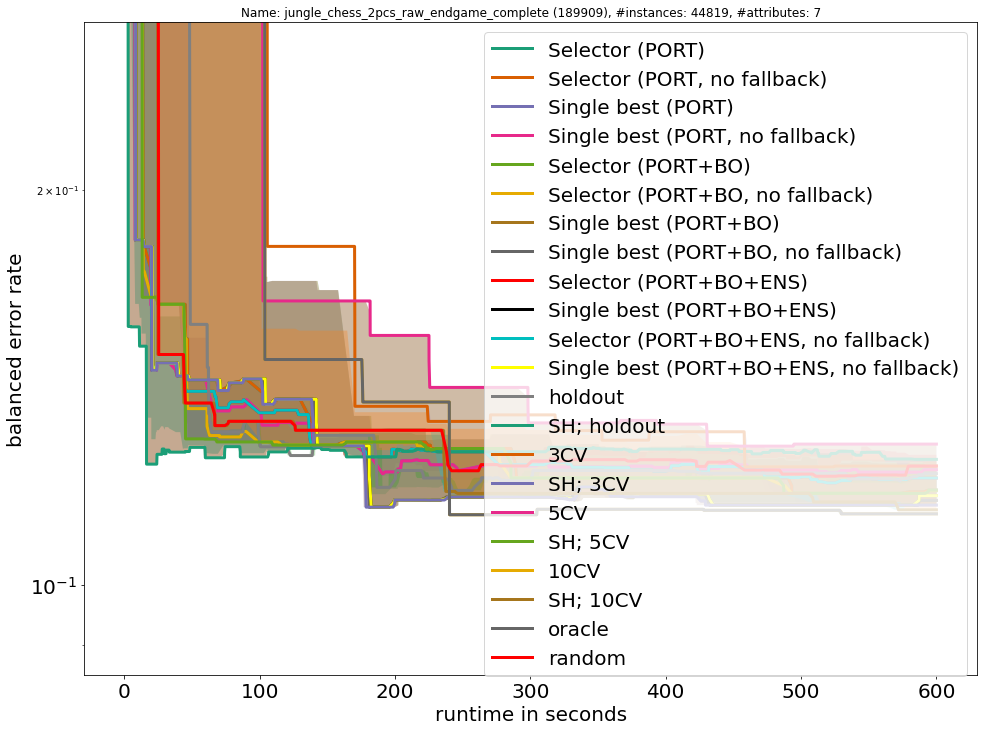

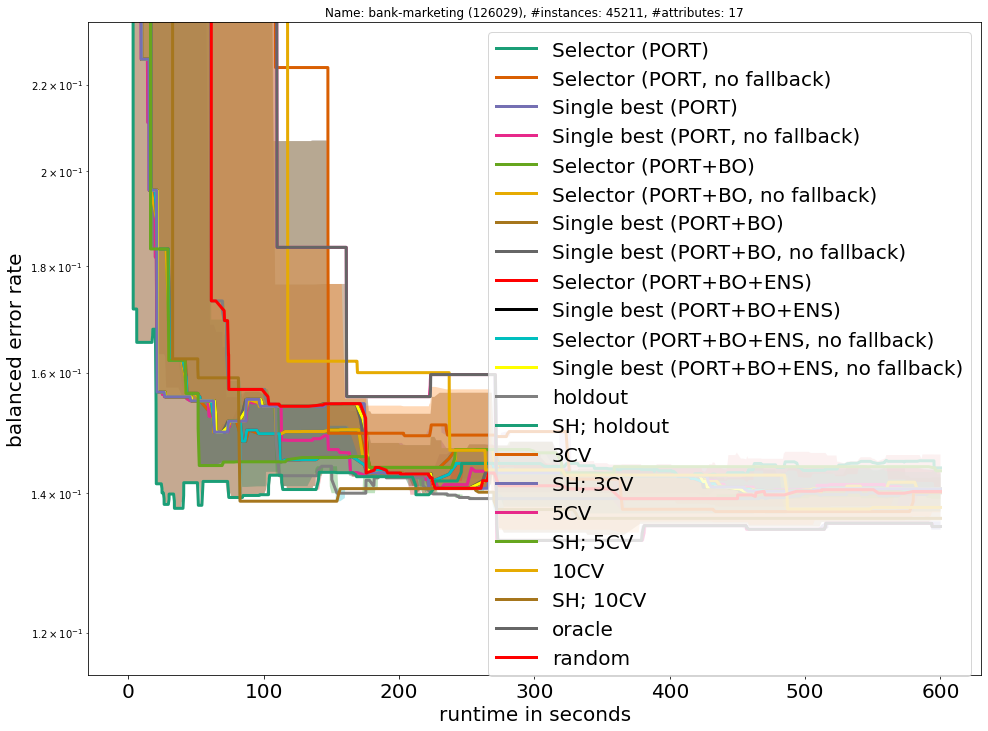

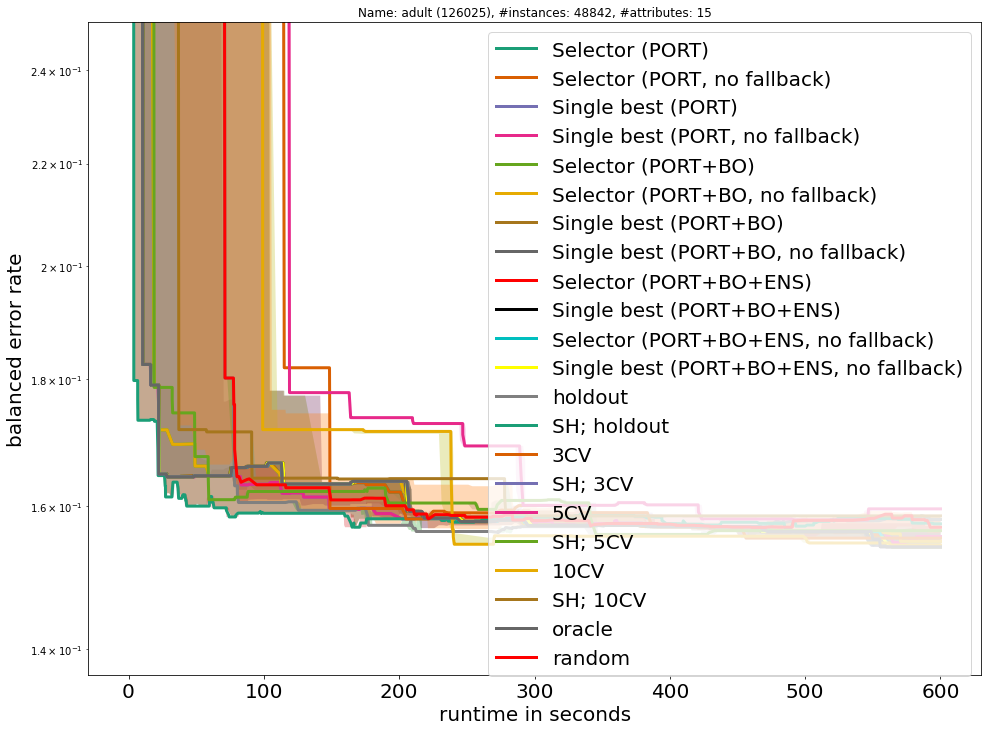

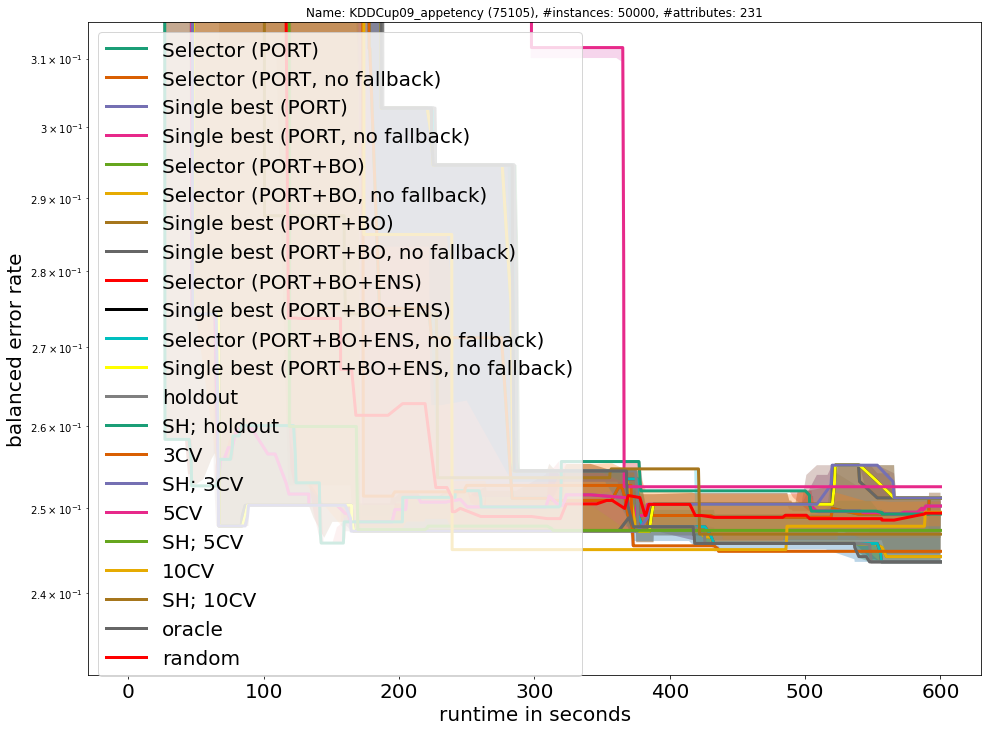

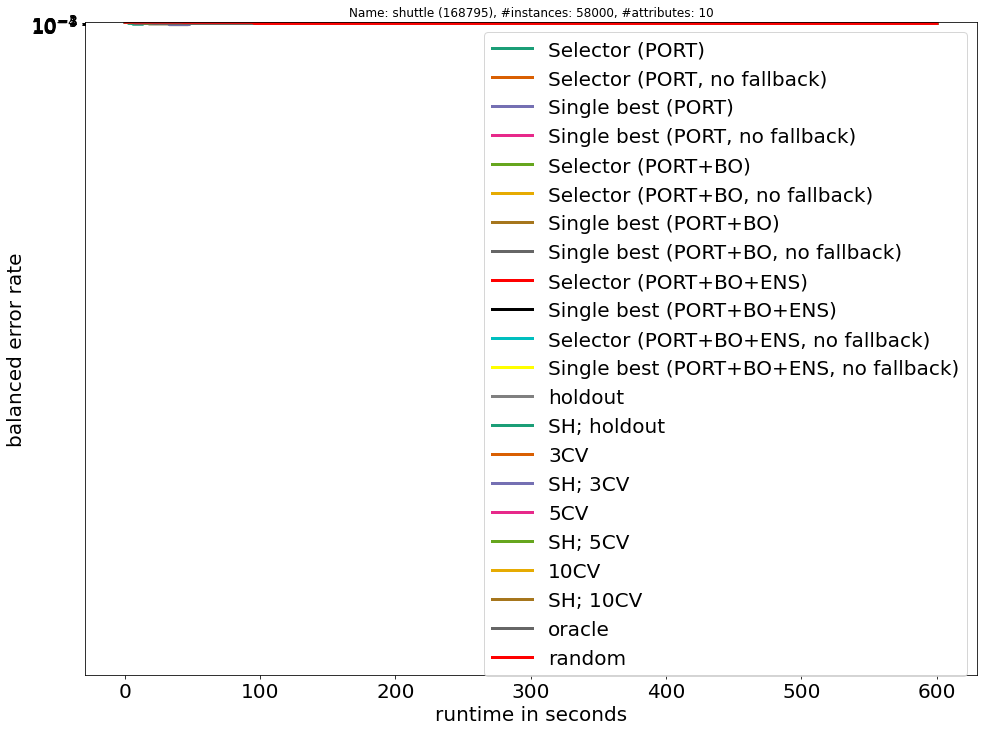

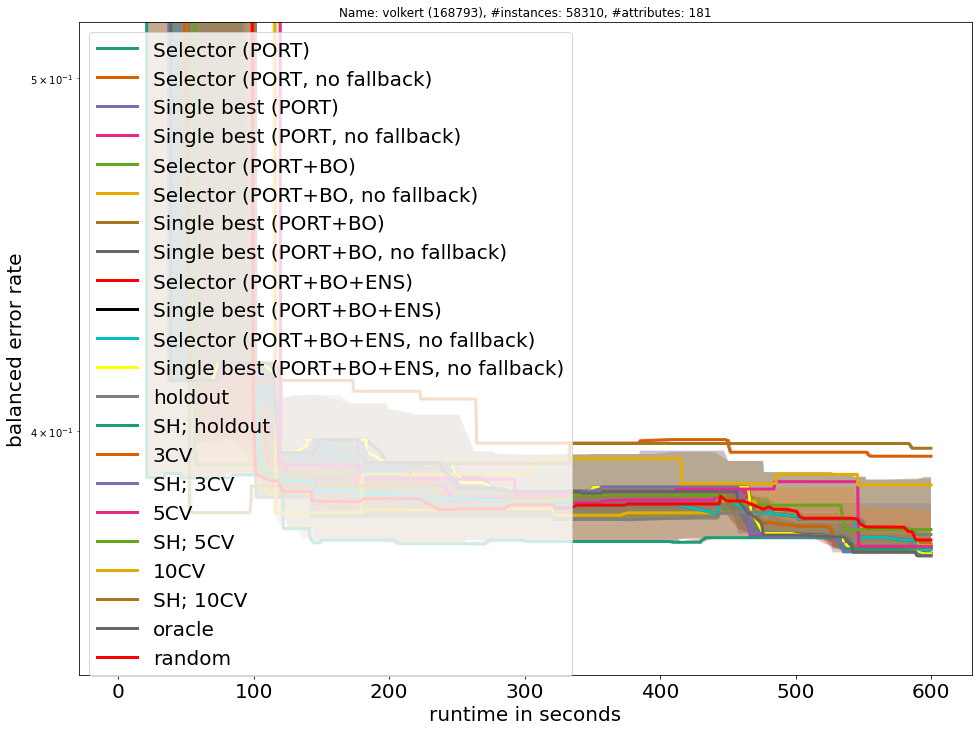

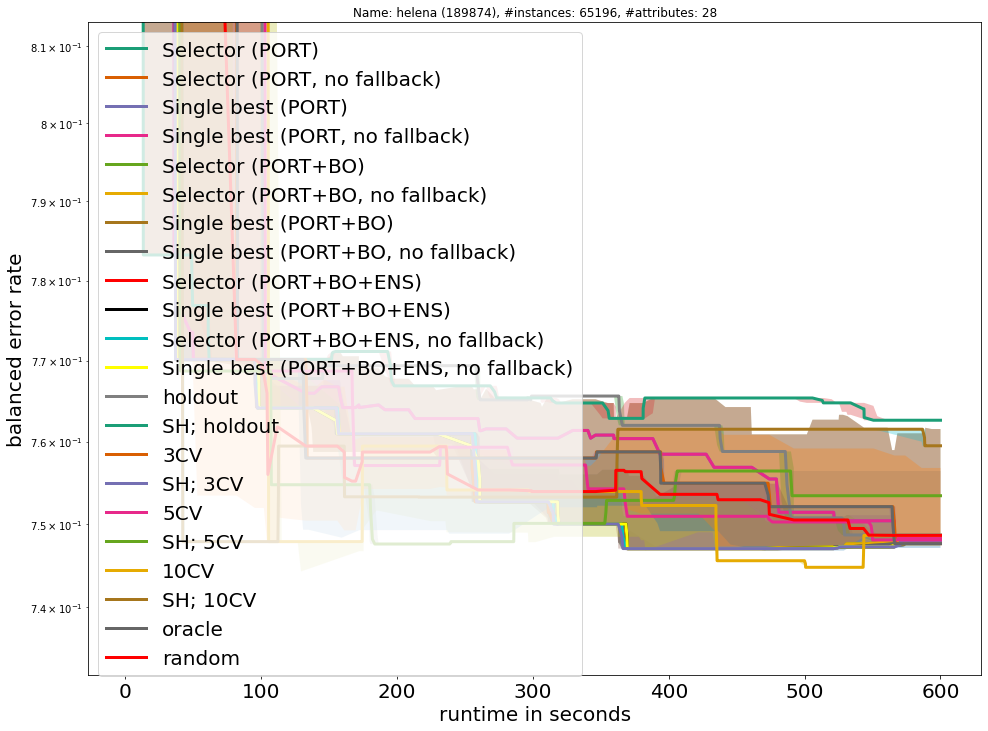

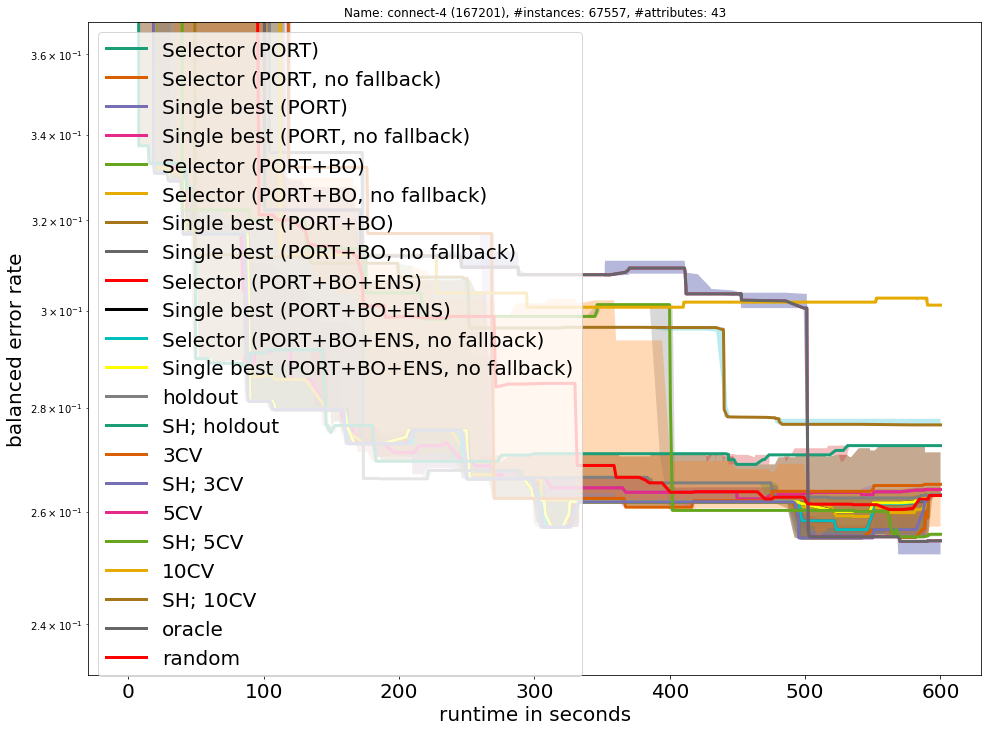

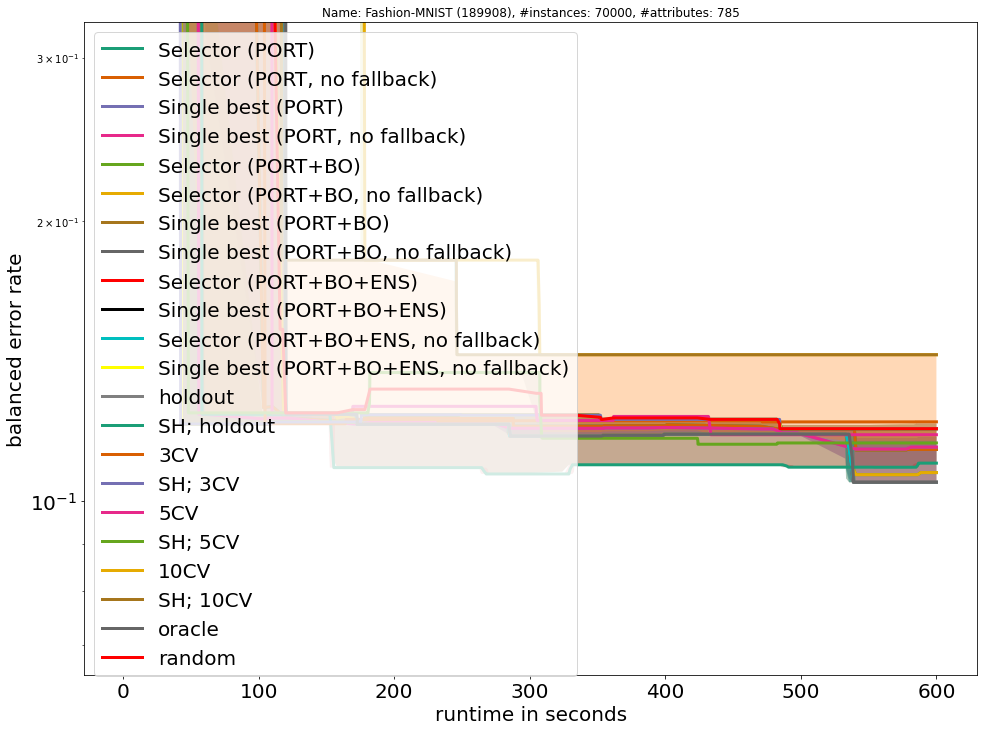

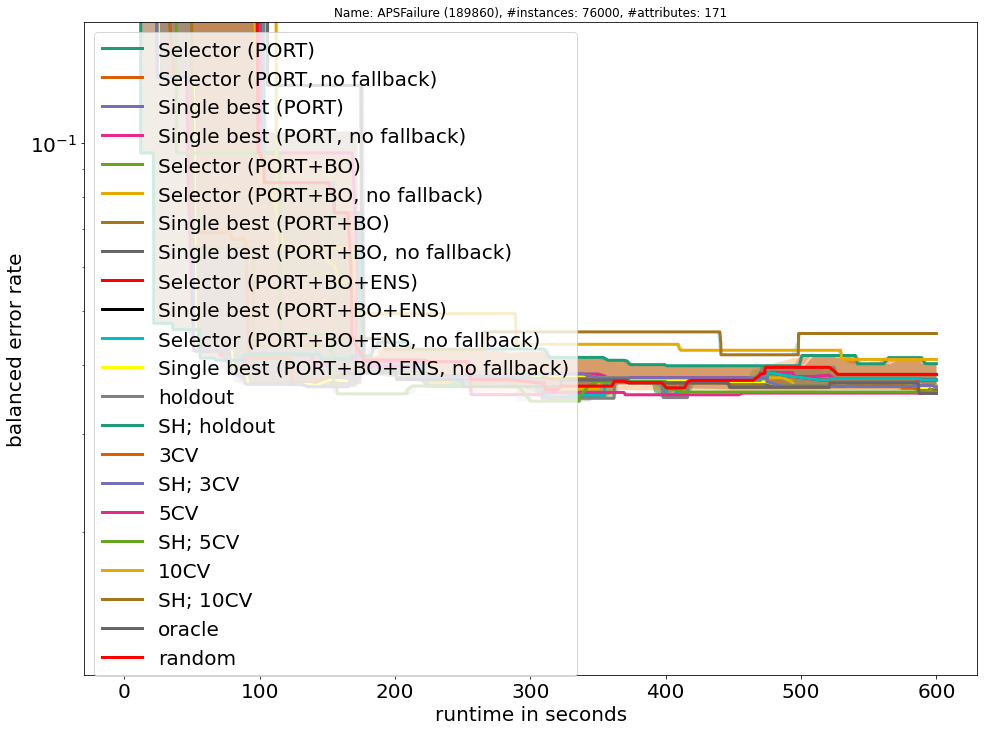

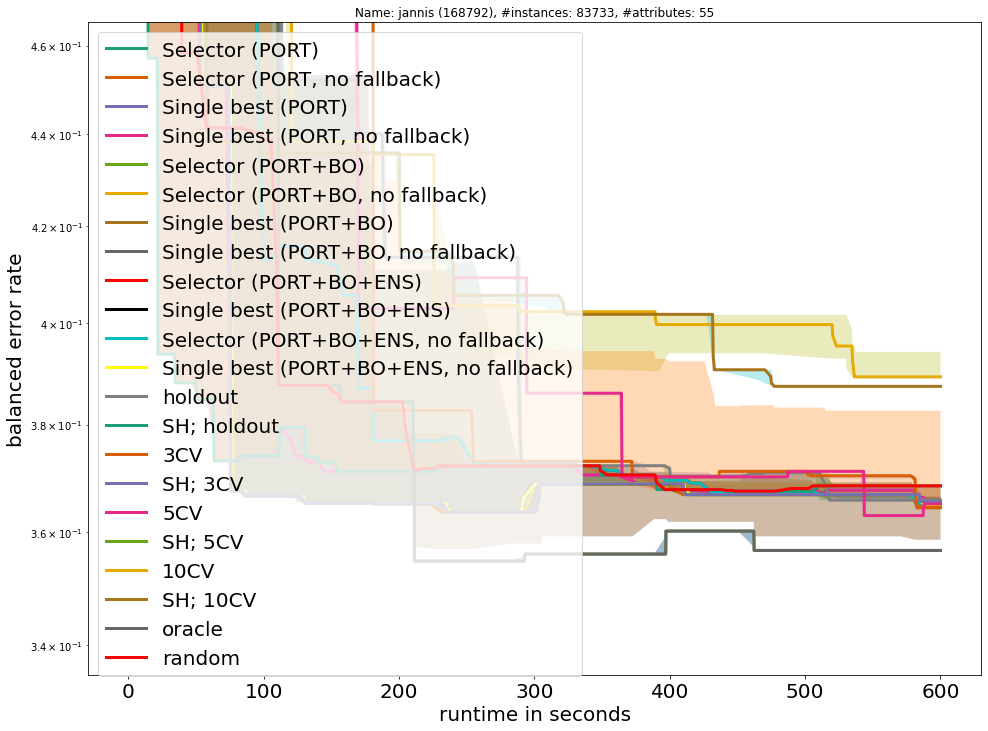

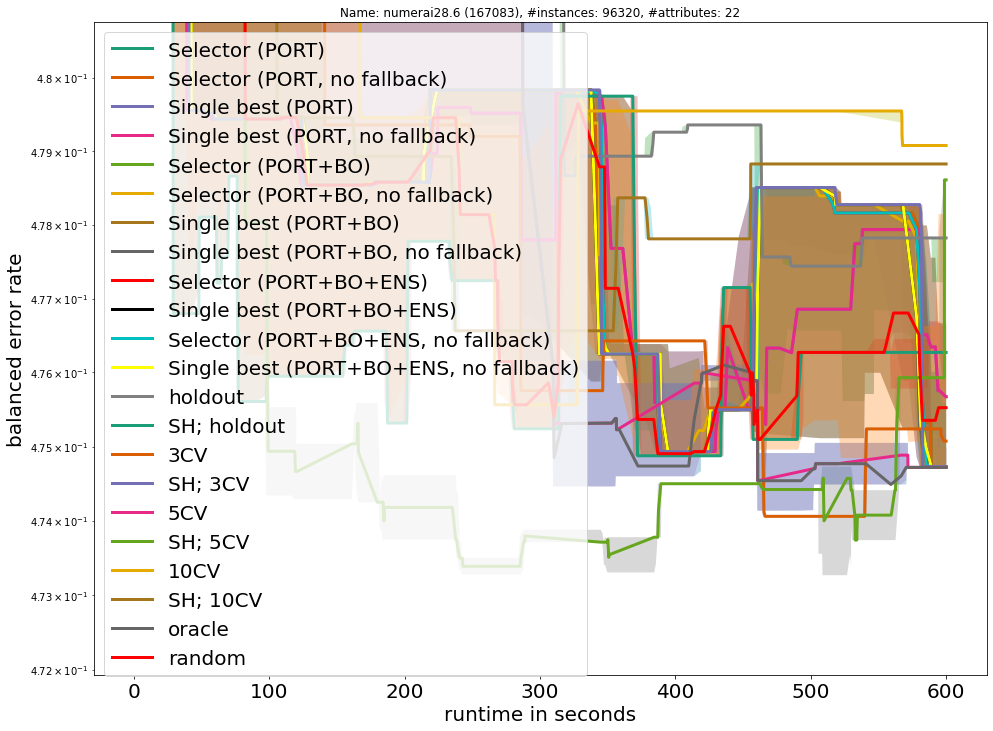

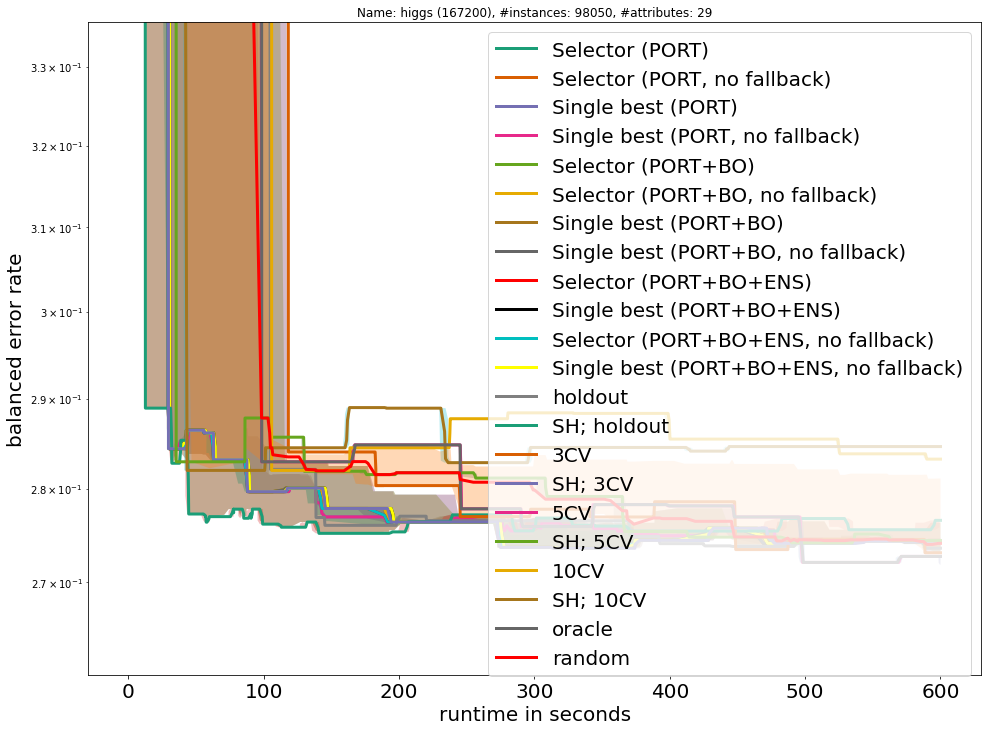

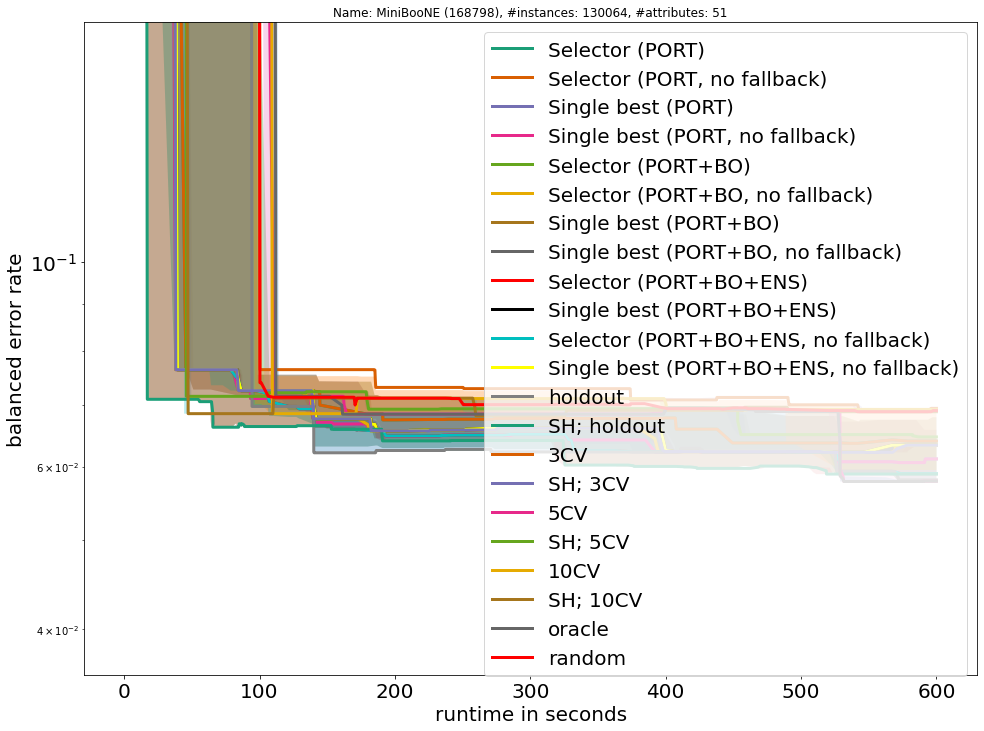

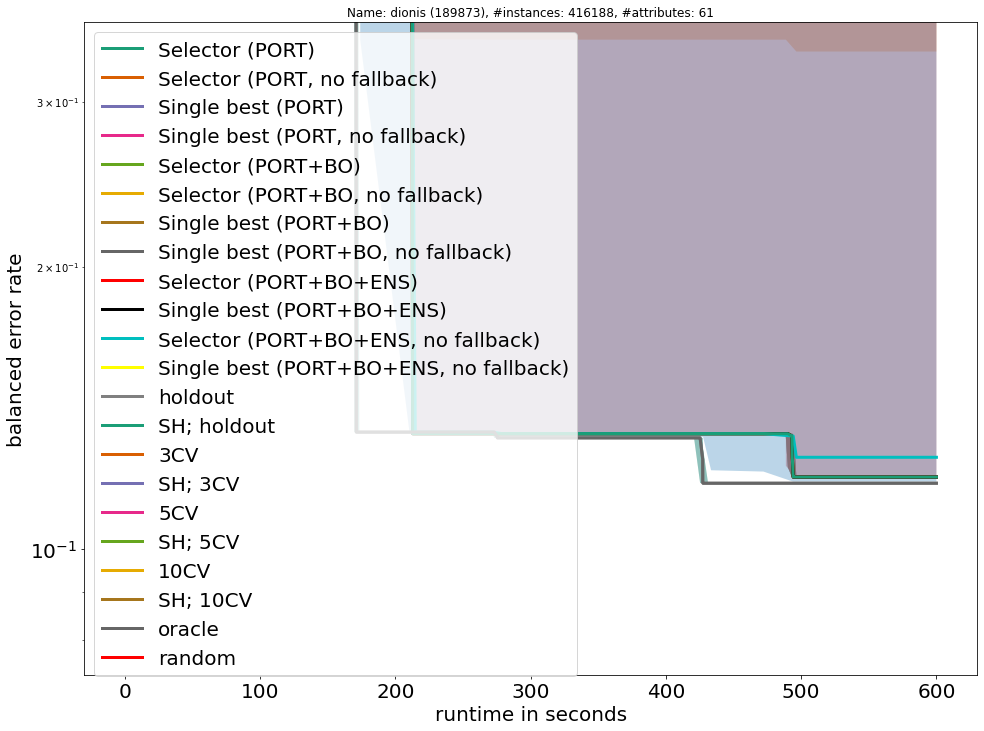

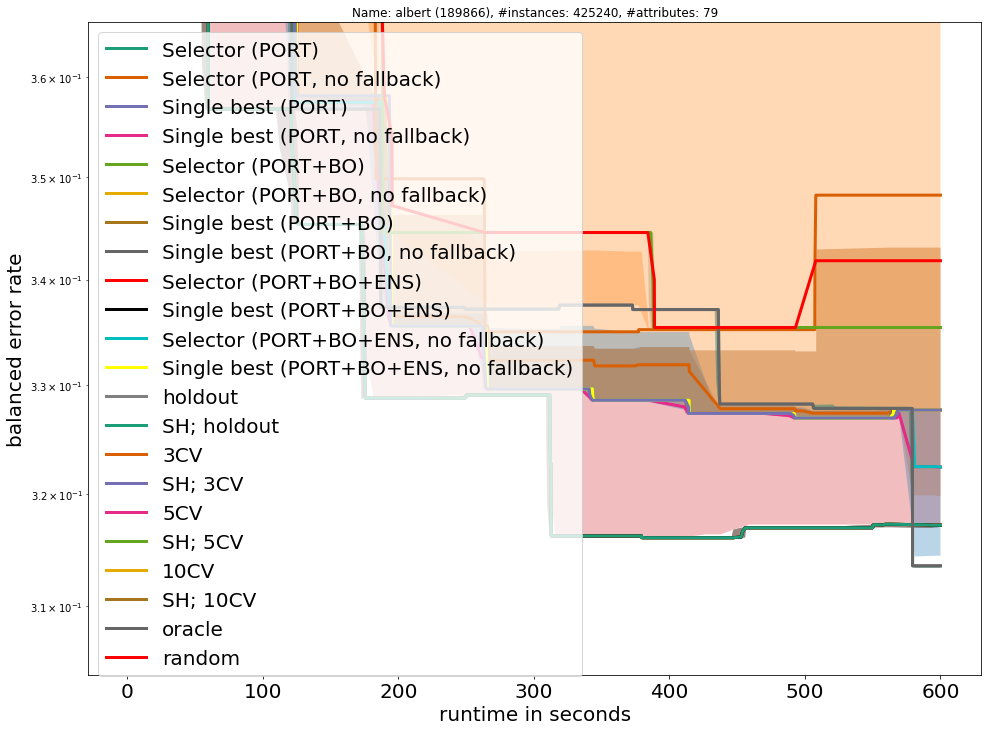

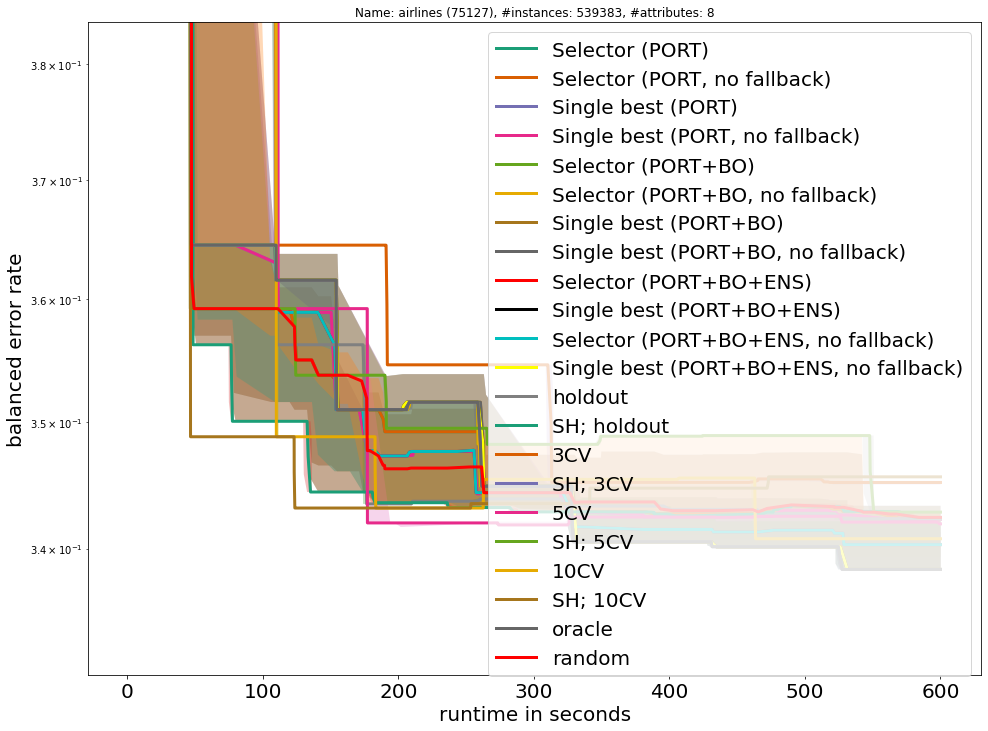

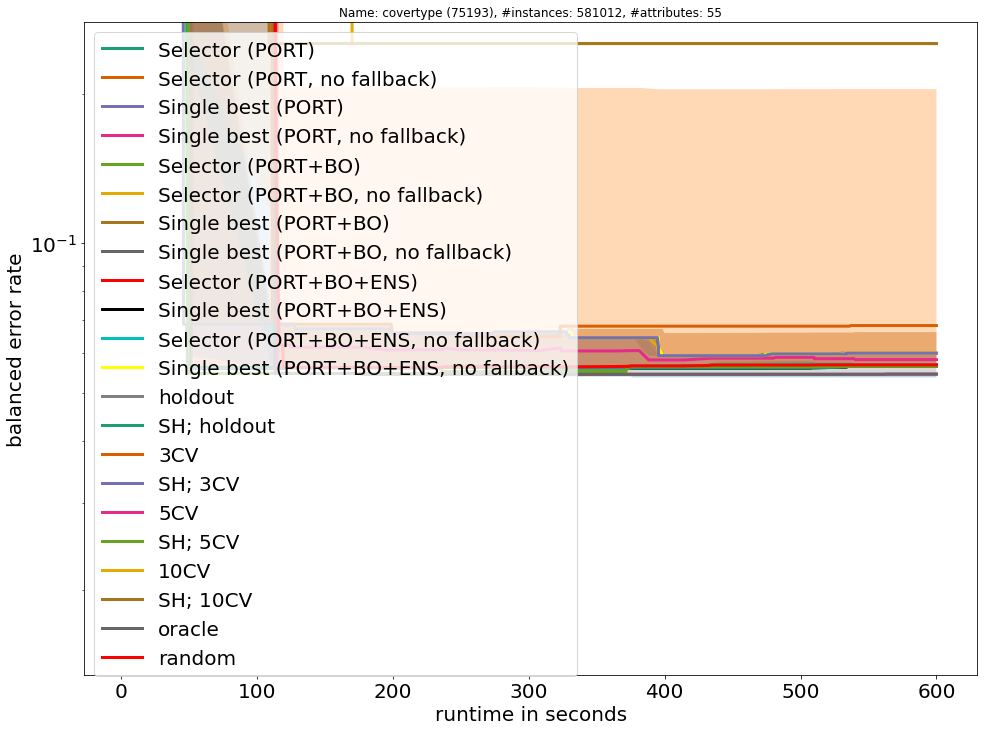

In [5]:
HORIZON = 10
for tid in task_ids_sorted_by_num_features:
    plt.figure(figsize=[16, 12])
    colors = itertools.cycle(style_dc["colors"] + ['yellow', 'grey'])
    for mode in list(valid_pretty[HORIZON].keys()):
        c = next(colors)
        tmp = pd.DataFrame(res_dc[HORIZON][tid][mode]).sort_index(axis=1).ffill(axis=1)
        med = tmp.median(axis=0)
        med.loc[HORIZON*60] = med.iloc[-1]
        low = tmp.quantile(0.25)
        low.loc[HORIZON*60] = low.iloc[-1]
        up = tmp.quantile(0.75, axis=0)
        up.loc[HORIZON*60] = up.iloc[-1]
        plt.plot(med.index, med.to_numpy(), 
                 label=valid_pretty[HORIZON][mode], linewidth=style_dc["linewidth"], color=c)
        plt.fill_between(med.index, low, up, alpha=0.3)
    plt.title('Name: %s (%d), #instances: %d, #attributes: %d' % (
        tasks.loc[tid, 'name'], tid, tasks.loc[tid, 'NumberOfInstances'], tasks.loc[tid, 'NumberOfFeatures']))
    plt.legend(fontsize=style_dc["fontsize"])
    plt.xticks(fontsize=style_dc["fontsize"])
    plt.yticks(fontsize=style_dc["fontsize"])
    plt.xlabel("runtime in seconds", fontsize=style_dc["fontsize"])
    plt.ylabel("balanced error rate", fontsize=style_dc["fontsize"])
    plt.ylim([plt.ylim()[0], plt.ylim()[0] + 0.3*(plt.ylim()[1]-plt.ylim()[0])])
    plt.yscale("log")
    plt.show()

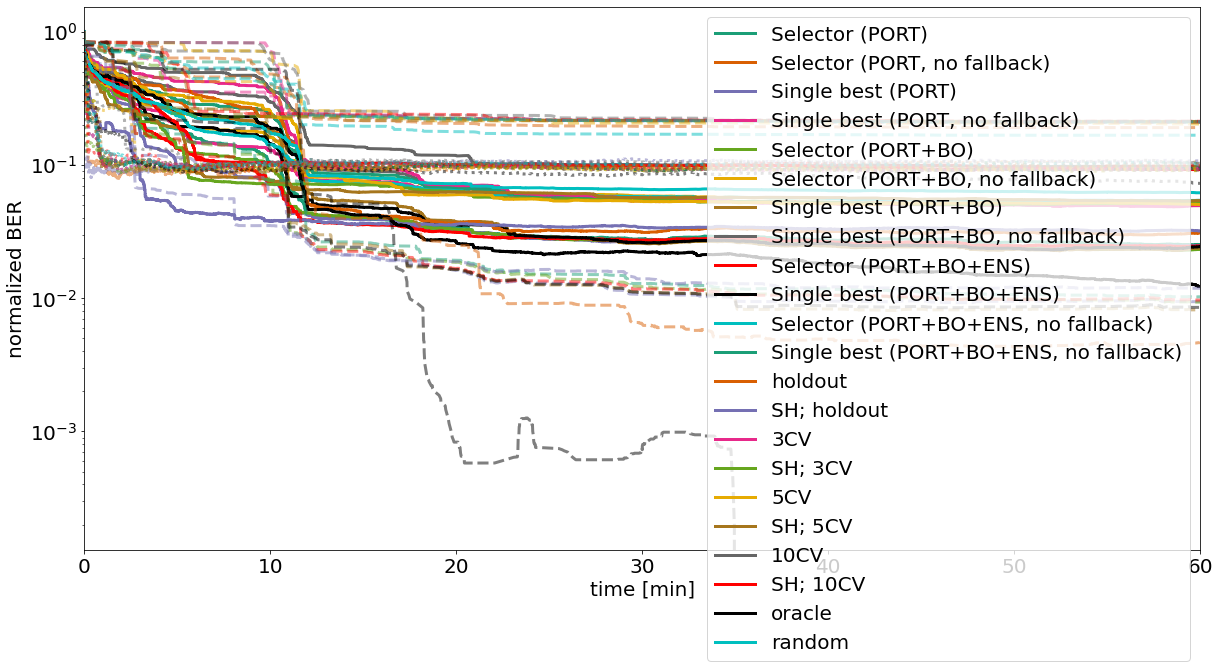

In [6]:
# Plot average BER across all datasets
HORIZON = 60
model_list = []
for m in valid_pretty[HORIZON].keys():
    model_list.append(m)
average_plot(model_list=model_list, res_dc=res_dc, valid_pretty=valid_pretty,
             horizon=HORIZON, task_ids_sorted_by_num_features=task_ids_sorted_by_num_features,
             min_diff_dc=min_diff_dc, figsize=(20, 10))
plt.yscale("log")
plt.show()

In [7]:
# Assume we have either all or no models
horizon_list = sorted(list(valid_pretty.keys()))
model_list = {}
for h in horizon_list:
    model_list[h] = []
    for m in valid_pretty[h].keys():
        model_list[h].append(m)

tab_data, stat_test_data = collect_data_for_final_table(
    model_list, res_dc, valid_pretty, horizon_list,
    task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds)
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, exclude=["oracle",])

Not different with 10 mins:
	 Selector (PORT+BO) vs Selector (PORT): 0.234641
	Selector (PORT+BO) vs Selector (PORT, no fallback): 0.109716
	Selector (PORT+BO) vs Selector (PORT+BO, no fallback): 0.124432
	Selector (PORT+BO) vs Single best (PORT+BO): 0.234641
	Selector (PORT+BO) vs Single best (PORT+BO, no fallback): 0.0857203
	Selector (PORT+BO) vs Selector (PORT+BO+ENS): 0.208113
	Selector (PORT+BO) vs Single best (PORT+BO+ENS): 0.152116
	Selector (PORT+BO) vs Selector (PORT+BO+ENS, no fallback): 0.0971755
	Selector (PORT+BO) vs Single best (PORT+BO+ENS, no fallback): 0.0542662
	Selector (PORT+BO) vs holdout: 0.0753072
	Selector (PORT+BO) vs SH; 3CV: 0.390084
	Selector (PORT+BO) vs 5CV: 0.706864
	Selector (PORT+BO) vs SH; 5CV: 0.115044
Not different with 60 mins:
	 Selector (PORT+BO) vs Single best (PORT+BO): 0.0611046
	Selector (PORT+BO) vs Selector (PORT+BO+ENS): 0.567394
	Selector (PORT+BO) vs Selector (PORT+BO+ENS, no fallback): 0.3077
	Selector (PORT+BO) vs 3CV: 0.120554
	Select

/home/feurerm/miniconda/3-4.5.4/envs/autosklearn/lib/python3.8/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [8]:
df = pd.DataFrame(tab_data)
#for horizon in horizon_list:
#    df['Rank_%s' % horizon] = df[horizon].rank(method='average', ascending=True)
print(df.to_latex())
print(not_different)

\begin{tabular}{lrrrr}
\toprule
{} &     10 &  STD 10 &    60 &  STD 60 \\
\midrule
Selector (PORT)                        &   3.58 &    0.11 &  2.53 &    0.33 \\
Selector (PORT, no fallback)           &   5.43 &    1.20 &  4.98 &    0.82 \\
Single best (PORT)                     &   3.88 &    0.24 &  2.49 &    0.13 \\
Single best (PORT, no fallback)        &   5.18 &    1.18 &  5.10 &    0.12 \\
Selector (PORT+BO)                     &   3.56 &    0.16 &  2.32 &    0.18 \\
Selector (PORT+BO, no fallback)        &   5.68 &    1.03 &  5.36 &    1.33 \\
Single best (PORT+BO)                  &   3.67 &    0.14 &  2.38 &    0.16 \\
Single best (PORT+BO, no fallback)     &   6.38 &    0.35 &  5.01 &    0.15 \\
Selector (PORT+BO+ENS)                 &   3.58 &    0.23 &  2.47 &    0.18 \\
Single best (PORT+BO+ENS)              &   3.69 &    0.14 &  2.44 &    0.12 \\
Selector (PORT+BO+ENS, no fallback)    &   4.79 &    1.36 &  5.43 &    2.22 \\
Single best (PORT+BO+ENS, no fallback) &   6.40

In [9]:
def table_per_dataset(model_list, res_dc, valid_pretty, horizon,
                      task_ids_sorted_by_num_features, min_diff_dc):
    # Generate data for final table and statistical testing
    tab_data = {}

    for mode in model_list:
        assert mode in valid_pretty[horizon], (mode, valid_pretty[horizon].keys())
        tab_data[valid_pretty[horizon][mode]] = {}
        # Use label, not actual key
        # Get means per tid
        for tid in task_ids_sorted_by_num_features:
            tmp = pd.DataFrame(res_dc[horizon][tid][mode]).sort_index(axis=1).ffill(axis=1).iloc[:, -1]
            assert tmp.shape == (n_seeds, )
            tmp = (tmp - min_diff_dc[tid][0]) / min_diff_dc[tid][1]
            tab_data[valid_pretty[horizon][mode]][tid] = tmp.mean()
    tab_data = pd.DataFrame(tab_data)
    return tab_data

tab_data = {}
for h in (10, 60):
    horizon_list = sorted(list(valid_pretty.keys()))
    model_list = []
    for m in valid_pretty[h].keys():
        if m[1]:
            model_list.append(m)

    tab_data[h] = table_per_dataset(model_list, res_dc, valid_pretty, h,
                                 task_ids_sorted_by_num_features, min_diff_dc)

In [10]:
print("Selector")
print((tab_data[10]['Selector (PORT+BO)'] - tab_data[10]['Selector (PORT+BO+ENS)']).sort_values())
print(tab_data[10]['Selector (PORT+BO)'].drop(189872).mean())
print(tab_data[10]['Selector (PORT+BO+ENS)'].drop(189872).mean())
print((tab_data[60]['Selector (PORT+BO)'] - tab_data[60]['Selector (PORT+BO+ENS)']).sort_values())
print(tab_data[60]['Selector (PORT+BO)'].drop(167168).mean())
print(tab_data[60]['Selector (PORT+BO+ENS)'].drop(167168).mean())
print("Single best")
print((tab_data[10]['Single best (PORT+BO)'] - tab_data[10]['Single best (PORT+BO+ENS)']).sort_values())
print((tab_data[60]['Single best (PORT+BO)'] - tab_data[60]['Single best (PORT+BO+ENS)']).sort_values())

Selector
189872   -0.011296
167181   -0.005511
167161   -0.003025
75127    -0.002700
75097    -0.002419
167200   -0.002238
189874   -0.002218
189909   -0.001792
167104   -0.001628
189865   -0.001531
167201   -0.001356
168792   -0.001352
167190   -0.001300
167149   -0.000847
189862   -0.000647
167185   -0.000451
167083   -0.000435
189871   -0.000349
189860   -0.000210
189906   -0.000009
189866    0.000000
189873    0.000000
75193     0.000000
168796    0.000000
168797    0.000000
168794    0.000000
168795    0.000041
126026    0.000117
189905    0.000189
126029    0.000684
167152    0.000910
167184    0.001241
126025    0.001668
168798    0.003222
75105     0.003280
168793    0.003977
189908    0.004193
167168    0.005415
189861    0.006168
dtype: float64
0.03605690394482556
0.03602831413744735
167168   -0.062326
167161   -0.008439
168792   -0.006755
75097    -0.004969
168793   -0.004507
189861   -0.004288
189871   -0.001672
167181   -0.001289
75127    -0.001002
167185   -0.000821
16879

In [11]:
print(np.sum(tab_data[60]['Single best (PORT)'] < tab_data[60]['Selector (PORT+BO+ENS)']))
print(np.sum(tab_data[60]['Single best (PORT)'] > tab_data[60]['Selector (PORT+BO+ENS)']))
print(np.sum(tab_data[60]['Selector (PORT)'] < tab_data[60]['Selector (PORT+BO+ENS)']))
print(np.sum(tab_data[60]['Selector (PORT)'] > tab_data[60]['Selector (PORT+BO+ENS)']))
print(np.sum(tab_data[60]['Selector (PORT+BO)'] < tab_data[60]['Selector (PORT+BO+ENS)']))
print(np.sum(tab_data[60]['Selector (PORT+BO)'] > tab_data[60]['Selector (PORT+BO+ENS)']))
print(np.sum(tab_data[60]['Single best (PORT+BO+ENS)'] < tab_data[60]['Selector (PORT+BO+ENS)']))
print(np.sum(tab_data[60]['Single best (PORT+BO+ENS)'] > tab_data[60]['Selector (PORT+BO+ENS)']))
print(np.sum(tab_data[60]['Selector (PORT+BO+ENS, no fallback)'] > tab_data[60]['Selector (PORT+BO+ENS)']))
print(np.sum(tab_data[60]['Selector (PORT+BO+ENS, no fallback)'] < tab_data[60]['Selector (PORT+BO+ENS)']))

14
19
12
21
14
19
12
21
4
2
